# Predicting Planting Intentions

## Background
Every year the USDA releases the results of a survey of planting intentions for farmers in the US. Responses are collected the first two weeks of March and released as an aggregate planting value for each state and crop combination. 

This notebook is an attempt to make a rough prediction of what this number may be, given data sources only up to the 29th of March (the day this data is released). 

It is important to note this prediction is done using a combination of previous years' data and current pricing information, and as such will *always* be less accurate than a representative sample of the exact intentions of farmers (as the USDA completes). However, it may give a useful indication of the trend or direction of change. 

## Methodology
There is a multitude of crop-state combinations released in the [USDA ERS](https://app.gro-intelligence.com/dictionary/sources/63) prospective plantings report. In this prototype model, we are focusing on predicting only the corn planted area (in ha), and only in the [corn belt](https://app.gro-intelligence.com/dictionary/regions/100000100). This restriction makes data collection and model optimization more tractable, but the approach would work for a variety of crop-region combinations in the real world.

In [5]:
import os
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.display import display
import pickle

In [6]:
# make the magic happen - import the Gro library
from api.client import Client
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

# get the years we have data available:
start_year = 1995
end_year = 2020
num_samples = end_year - start_year

In [ ]:
# pull the corn belt states from Gro
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', 100000100)["contains"]
}

# resreg = resource region as defined by ers
county_to_resreg = {}
state_to_counties = {}
state_training_data = {}

# get data on the counties in these states
for state_id in state_ids.values():
    state_obj = client.lookup("regions", state_id)
    # the contains field will contain all the next level region data - i.e. counties in this case (aka districts)
    state_to_counties[state_id] = []
    
    # find first county that has an ers region
    for county in state_obj["contains"]:
        
        county_obj = client.lookup("regions", county)
        
        # counties are always level 5
        if county_obj["level"] != 5:
            continue
        
        state_to_counties[state_id].append(county)
        
        for parent_region_obj in client.lookup_belongs("regions", county):
            # resource regions happen to be in this interval of ids
            if parent_region_obj["id"] in range(100000140, 100000149):
                county_to_resreg[county] = parent_region_obj ["id"]
            
        if county not in county_to_resreg:
            print("couldn't find a resreg for county with id %s and name %s in state %s, deleting" % (county, county_information["name"], result["name"]))
            del state_to_counties[state_id][state_to_counties[state_id].index(county)]
            

## Features

As with any statistical model, we have to collect a number of features of predictor data. Based on domain expertise, we have selected a number of data features available in Gro. The features are grouped by the region granularity that they are available at (country, state, county, and "Ag Districts", which ERS-defined regions grouping counties within states -- e.g. [Alabama Ag District 40](https://app.gro-intelligence.com/dictionary/regions/100000197)), as well as their requisite item, metric pairs for access via Gro. 

In [32]:
def get_all_subitems(item_id):
    # use a set because 
    item_set = set([item_id])
    for sub_item_id in client.lookup("items", item_id)["contains"]:
        item_set |= get_all_subitems(sub_item_id)
    return item_set

In [33]:
# Define the crops we use in the model as predictors.
crop_ids = {
    "corn": 274,
    "soybeans": 270,
    "wheat": 95,
    "cotton": 7077
}

crop_ids_expanded = {crop_name: get_all_subitems(crop_id) for (crop_name, crop_id) in crop_ids.iteritems()}

In [34]:
# Define all the data series we may be interested in. This is collected from the Viz. 
features = {
    "country": {
        "futures_price_dec_march": { # for corn we miss this for 1995-1997 so just impute it from fixed values..
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (3, 28),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065, #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_june": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (6, 30),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065, #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_nov": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (11, 10), #bit earlier as some futures don't have december only nov 30 expiration.
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065,  #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "producer_prices_country_yearly": { # no need to impute - fully downloaded
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_country_march": {
            'impute': "producer_prices_yearly", # impute with yearly values if something's missing.
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        }
    },
    "ers_region": {
        "operating_costs_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850182, 
            'source_id': 63, 
            'frequency_id': 9
        },
        "overhead_costs_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850183,
            'source_id': 63, 
            'frequency_id': 9
        },
        "land_opportunity_cost_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 8591080, 
            'source_id': 63, 
            'frequency_id': 9
        }
    },
    "state": {
        "area_planted_state_march": {
            'feature_type': 'relative', # this is relative to county levels. 
            'impute': "area_planted_nass_final_state", # use the state value.
            'impute_type': "same",
            'report_date': (3, 31),
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "producer_prices_yearly": { # no need to impute - fully downloaded
            'impute': "producer_prices_country_yearly", # impute with yearly values if something's missing.
            'impute_type': 'same',
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_march": {
            'impute': "producer_prices_country_march", # impute with yearly values if something's missing.
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        },
        "area_planted_nass_final_state": { #nothings missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass_state": { #nothings missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass_state": { #nothings missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass_state": { #nothings missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850168, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_failed_non_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850173,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "fsa_area_planted_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_planted_non_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "area_planted_nass_final": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass": {
            'feature_type': 'relative',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    }
}


In [ ]:
# Other data series that could potentially be used in the future.
# Up to the reader to implement.

other_data_series = {
    #yearly, country level
    "interest_rate_us": {
        'level': 3,
        'metric_id': 5020042, 
        'item_id': 4512, 
        'region_id': 1215, 
        'source_id': 25, 
        'frequency_id': 9
    },
    "cpi_us": {
        'metric_id': 950029, 
        'item_id': 4504, 
        'region_id': 1215, 
        'source_id': 6, 
        'frequency_id': 9
    }
}

In [36]:
def get_features_list(features):
    features_list = []
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                features_list.append("%s_%s" % (series_name, crop_name))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
display(pd.DataFrame(features_list))
print("proceeding to download {} features".format(num_features))

0
0           futures_price_dec_june_soybeans
1               futures_price_dec_june_corn
2              futures_price_dec_june_wheat
3             futures_price_dec_june_cotton
4            futures_price_dec_nov_soybeans
5                futures_price_dec_nov_corn
6               futures_price_dec_nov_wheat
7              futures_price_dec_nov_cotton
8          futures_price_dec_march_soybeans
9              futures_price_dec_march_corn
10            futures_price_dec_march_wheat
11           futures_price_dec_march_cotton
12   producer_prices_country_march_soybeans
13       producer_prices_country_march_corn
14      producer_prices_country_march_wheat
15     producer_prices_country_march_cotton
16  producer_prices_country_yearly_soybeans
17      producer_prices_country_yearly_corn
18     producer_prices_country_yearly_wheat
19    producer_prices_country_yearly_cotton
20              overhead_costs_ers_soybeans
21                  overhead_costs_ers_corn
22                 overhead_costs_ers_wheat
23                overhead_costs_ers_cotton
24       land_opportunity_cost_ers_soybeans
25           land_opportunity_cost_ers_corn
26          land_opportunity_cost_ers_wheat
27         land_opportunity_cost_ers_cotton
28             operating_costs_ers_soybeans
29                 operating_costs_ers_corn
30                operating_costs_ers_wheat
31               operating_costs_ers_cotton
32        area_planted_state_march_soybeans
33            area_planted_state_march_corn
34           area_planted_state_march_wheat
35          area_planted_state_march_cotton
36           producer_prices_march_soybeans
37               producer_prices_march_corn
38              producer_prices_march_wheat
39             producer_prices_march_cotton
40                yield_nass_state_soybeans
41                    yield_nass_state_corn
42                   yield_nass_state_wheat
43                  yield_nass_state_cotton
44          producer_prices_yearly_soybeans
45              producer_prices_yearly_corn
46             producer_prices_yearly_wheat
47            producer_prices_yearly_cotton
48   area_planted_nass_final_state_soybeans
49       area_planted_nass_final_state_corn
50      area_planted_nass_final_state_wheat
51     area_planted_nass_final_state_cotton
52           production_nass_state_soybeans
53               production_nass_state_corn
54              production_nass_state_wheat
55             production_nass_state_cotton
56       area_harvested_nass_state_soybeans
57           area_harvested_nass_state_corn
58          area_harvested_nass_state_wheat
59         area_harvested_nass_state_cotton
60       fsa_area_failed_irrigated_soybeans
61           fsa_area_failed_irrigated_corn
62          fsa_area_failed_irrigated_wheat
63         fsa_area_failed_irrigated_cotton
64                      yield_nass_soybeans
65                          yield_nass_corn
66                         yield_nass_wheat
67                        yield_nass_cotton
68  fsa_area_planted_non_irrigated_soybeans
69      fsa_area_planted_non_irrigated_corn
70     fsa_area_planted_non_irrigated_wheat
71    fsa_area_planted_non_irrigated_cotton
72   fsa_area_failed_non_irrigated_soybeans
73       fsa_area_failed_non_irrigated_corn
74      fsa_area_failed_non_irrigated_wheat
75     fsa_area_failed_non_irrigated_cotton
76      fsa_area_planted_irrigated_soybeans
77          fsa_area_planted_irrigated_corn
78         fsa_area_planted_irrigated_wheat
79        fsa_area_planted_irrigated_cotton
80         area_planted_nass_final_soybeans
81             area_planted_nass_final_corn
82            area_planted_nass_final_wheat
83           area_planted_nass_final_cotton
84                 production_nass_soybeans
85                     production_nass_corn
86                    production_nass_wheat
87                   production_nass_cotton
88             area_harvested_nass_soybeans
89                 area_harvested_nass_corn
90                area_harvested_nass_

proceeding to download 92 features


## Data download from Gro

Gro data is provided in a "raw" form - that is, we do minimal post-processing in order to allow the end-user the most flexibility in handling the data. This means we do not impute values in the API on our end and we try to provide it in a way as close as possible to the ground truth data from the source. 

The data points themselves are provided as simple point-value pairs or triplets. The most basic case of a time-series is simply points associated with a given timestamp. However, in some cases a point is revised or re-released from a source - in this case each point is associated with two time-staps - a "reporting date and an "end date". 

The following code snippet downloads and picks data points from the time series which are relevant to the analysis.

In [ ]:
### IMPORTANT ###
# If you wish to load this data from a saved pickle file, skip this cell and run the next one.
### IMPORANT ###

for state_id in state_ids.values():

    num_counties = len(state_to_counties[state_id])
    training_data = np.ma.zeros((num_counties, num_samples, num_features))
    state_training_data[state_id] = training_data
    
    feature_idx = 0
    
    # Get all the crop-specific data series
    for region_type in ["country", "ers_region", "state", "county"]:
        for series_name, query in features[region_type].items():
            for crop_name in crop_ids.keys():
                
                crop_ids_to_check = crop_ids_expanded[crop_name]
                
                for county_idx, county_id in enumerate(state_to_counties[state_id]):
                    
                    # this must be a set because ontology isn't necessarily a tree
                    useful_series = []
                    
                    for crop_id in crop_ids_to_check:
                        
                        query["item_id"] = crop_id

                        if query['level'] == 8:
                            query["region_id"] = county_to_resreg[county_id]
                        elif query['level'] == 5:
                            query['region_id'] = county_id
                        elif query['level'] == 4:
                            query['region_id'] = state_id
                        elif query['level'] == 3:
                            query['region_id'] = 1215

                        result = client.get_data_series(**query)

                        for possible_series in result: 
                            series_start_year = int(possible_series["start_date"][0:4])
                            series_end_year = int(possible_series["end_date"][0:4])
                            if ((series_start_year <= start_year < series_end_year) 
                                                       or (series_start_year < end_year <= series_end_year)
                                                       or (start_year <= series_start_year and series_end_year <= end_year)):
                                useful_series.append(possible_series)
                    
                    if not useful_series:
                        print("NO DATA FOR %s in %s for %s, county_idx=%i, feature=%i" % 
                              (series_name, state_id, crop_name, county_idx, feature_idx))
                        
                    for series in useful_series:

                        if "show_revisions" in query and query["show_revisions"]:
                            series["show_revisions"] = True

                        # Let's actually download the data
                        data_points = client.get_data_points(**series)
                        number_sample_points = 0

                        cache = np.ma.zeros(num_samples)
                        cache[:] = np.ma.masked

                        for point in data_points:
                            # if we have a sample date specified, let's pick the point that's closest to this point
                            last_sampled_date = None
                            last_reported_date = None
                            sample_deadline = datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) if "sample_date" in query else None 
                            report_deadline = datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) if "report_date" in query else None 
                            if "reporting_date" in point and point["reporting_date"] is not None:
                                reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                            else:
                                reported_date = None
                            end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                            sample_idx = int(point["end_date"][0:4]) - start_year

                            if 0 <= sample_idx < num_samples:

                                if sample_deadline is not None and end_date > sample_deadline :
                                    # continue to next point as this is after the date we want to grab it.
                                    continue
                                if last_sampled_date is not None and end_date < last_sampled_date:
                                    # newer sample date avail, ignoring this point
                                    continue
                                if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
                                    # past report deadline
                                    continue
                                if last_reported_date is not None and reported_date < last_reported_date:
                                    # newer report date avail
                                    continue
                                
                                # unmask potentially
                                if cache[sample_idx] == np.ma.masked:
                                    cache[sample_idx] = 0.0
                                
                                # some items are item groups and thus need to be sum-aggregated
                                if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                    cache[sample_idx] +=  point["value"]
                                else:
                                    cache[sample_idx] = point["value"]
                                    last_sampled_date = end_date
                                    last_reported_date = reported_date

                                number_sample_points += 1
                    
                        # masked + nonmasked => masked
                        training_data[county_idx, :, feature_idx] += cache

                        print("Downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % 
                              (series_name, state_id, series["item_name"], county_idx, number_sample_points, feature_idx))
                    # if the data we're getting is not county level - use this for all other counties and go to next feature
                    if query["level"] == 4 or query["level"] == 3:
                        print("copying state or country data to other counties so we don't have to download")
                        training_data[:, :, feature_idx] = training_data[county_idx, :, feature_idx]
                        break

                # download the next feature
                feature_idx += 1

#### uncomment to save this data pull
# pickle.dump(state_training_data, open("state_data.pickle", "wb"))
###

In [47]:
#### uncomment this to load this from a saved state, saving time from the download process.
# state_training_data = pickle.load(open("state_data.pickle", "rb"))
###

In [58]:
### different strategies to imputate things with missing values.

imputed_state_training_data = {}

for name, state_id in state_ids.items():
    training_data = state_training_data[state_id]

    training_data = training_data.copy()
    imputed_state_training_data[state_id] = training_data
    feature_idx = -1
    
    # Get all the crop-specific data series info
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                feature_idx += 1
                if "impute" not in series:
                    if np.ma.is_masked(training_data[:, :, feature_idx]):
                        continue
                elif "impute" in series:
                    if series["impute"] != "impute":
                        reference_name = series["impute"] + "_" + crop_name
                        reference_idx = features_list.index(reference_name)
                    
                    # case: copy over the values from somewhere else (e.g. state to county prices)
                    if "impute_type" in series and series["impute_type"] == "same":
                        print("doing copying of values for  {}".format(features_list[feature_idx]))
                        training_data[:, :, feature_idx][training_data.mask[:, :, feature_idx]] = \
                        training_data[:, :, reference_idx][training_data.mask[:, :, feature_idx]]
                    # case: do a 1-variable regression with regards to some reference timeseries to impute the values.
                    elif "impute_type" in series and series["impute_type"] == "relative":
                        print("doing regression  {}".format(features_list[feature_idx]))
                        for county_idx in range(len(state_to_counties[state_id])):
                            invalid_idxs = training_data.mask[county_idx, :, feature_idx]
                            if not np.any(invalid_idxs):
                                continue
                            valid_idxs = ~invalid_idxs
                            if not np.any(valid_idxs):
                                training_data[county_idx, :, feature_idx] = 0.0
                                continue
                            reg = LinearRegression().fit(training_data[county_idx, valid_idxs, reference_idx].reshape(-1, 1), 
                                                         training_data[county_idx, valid_idxs, feature_idx].reshape(-1, 1))
                            #print(training_data[county_idx, invalid_idxs, reference_idx].reshape(-1, 1))
                            imputed_vals = reg.predict(training_data[county_idx, invalid_idxs, reference_idx].reshape(-1, 1))
                            training_data[county_idx, invalid_idxs, feature_idx] = imputed_vals[:,0]
                    # case: take the mean for that *county* across all years (sample expected value over time) and use that to impute missing values
                    else:
                        #just naively impute it
                        training_data_avgs = np.ma.repeat(np.expand_dims(training_data.mean(axis=0), axis=0), training_data.shape[-3], axis=0)
                        if np.any(training_data.mask[:,:,feature_idx]):
                            print("doing naive filling for  {} for {}/{} values".format((features_list[feature_idx]), np.count_nonzero(training_data.mask[:,:,feature_idx]), training_data.mask[:,:,feature_idx].size))
                        training_data[:, :, feature_idx] = np.ma.where(training_data.mask, training_data_avgs, training_data)[:, :, feature_idx]

doing regression  futures_price_dec_june_soybeans
doing regression  futures_price_dec_june_corn
doing regression  futures_price_dec_june_wheat
doing regression  futures_price_dec_june_cotton
doing regression  futures_price_dec_nov_soybeans
doing regression  futures_price_dec_nov_corn
doing regression  futures_price_dec_nov_wheat
doing regression  futures_price_dec_nov_cotton
doing regression  futures_price_dec_march_soybeans
doing regression  futures_price_dec_march_corn
doing regression  futures_price_dec_march_wheat
doing regression  futures_price_dec_march_cotton
doing copying of values for  producer_prices_country_march_soybeans
doing copying of values for  producer_prices_country_march_corn
doing copying of values for  producer_prices_country_march_wheat
doing copying of values for  producer_prices_country_march_cotton
doing naive filling for  producer_prices_country_yearly_soybeans for 264/1650 values
doing naive filling for  producer_prices_country_yearly_corn for 264/1650 value

In [67]:
# generate our X,y for training models on. 
# also output a "true y" that's not yoy for visualization later

print("generating training and test data matrices")

X = None
y = {} # key is crop_name
y_full_area = {}
state_index_map = {}

FLAGS = { 
    "yoy": True, # model the year-over-year delta (first order different in time)
    "norm_rel_features": True # normalize >district features to district level according to earlier planted area.
}

curr_year_features = []
curr_year_features += ["futures_price_dec_march_{}".format(crop_name) for crop_name in crop_ids.keys()]
curr_year_features += ["producer_prices_march_{}".format(crop_name) for crop_name in crop_ids.keys()]
prev_year_features = features_list

for name, state_id in state_ids.items():

    training_data = imputed_state_training_data[state_id]
    training_data = np.array(training_data, copy=True)        
    training_data_backup_pre_norm = np.array(training_data, copy=True)

    # weight relative features with production quantities for that county for the last year.
    if FLAGS["norm_rel_features"]:
        feature_idx = 0
        for region_type in ["country", "ers_region", "state", "county"]:
            region_series = features[region_type]
            for series_name, series in region_series.items():
                for crop_name in crop_ids.keys():
                    if "feature_type" in series and series["feature_type"] == "relative":
                        area_planted_index = features_list.index("area_planted_nass_final_" + 
                                                                 crop_name)
                        training_data[:, :, feature_idx] *= np.roll(training_data[:, :, area_planted_index], 1, axis=1)
                    feature_idx += 1
        
    # pull out the features we are interested in
    curr_year_feature_idxs = [features_list.index(feature_name) for feature_name in curr_year_features]
    prev_year_feature_idxs = [features_list.index(feature_name) for feature_name in prev_year_features]

    # shift us one full year so we never happen to use non-avail data
    train_data = np.concatenate((np.roll(training_data, -1, axis=1)[:, :-1, curr_year_feature_idxs],
                                training_data[:, :-1, prev_year_feature_idxs]), axis=2)
    
    for crop in ["corn"]:
        print("saving outputs for crop: {} & state: {}".format(crop, name))
        
        #add values for this year
        y_feature_index = features_list.index("area_planted_nass_final_" + crop)
        y_feature_index_state = features_list.index("area_planted_state_march_" + crop)
        test_data = np.array(training_data_backup_pre_norm[:, :, y_feature_index], copy=True)
        test_data_orig = np.array(training_data_backup_pre_norm[:, :, y_feature_index], copy=True)
        
        # year on year
        if FLAGS["yoy"]:
            test_data -= np.roll(test_data, 1, axis=1)

        test_data = test_data[:,1:]
        test_data_orig = test_data_orig[:, 1:]
        
        if crop not in y:
            y[crop] = test_data
            y_full_area[crop] = test_data_orig
        else:
            y[crop] = np.concatenate([y[crop], test_data], axis=0)
            y_full_area[crop] = np.concatenate([y_full_area[crop], test_data_orig], axis=0)
    
    print("saving features for state: {}".format(crop, name))
    if X is None:
        state_index_map[state_id] = (0, train_data.shape[0])
        X = np.nan_to_num(train_data)
    else:
        state_index_map[state_id] = (X.shape[0], X.shape[0] + train_data.shape[0])
        X = np.concatenate([X, np.nan_to_num(train_data)], axis=0)

generating training and test data matrices
saving outputs for crop: corn & state: South Dakota
saving features for state: corn
saving outputs for crop: corn & state: Iowa
saving features for state: corn
saving outputs for crop: corn & state: Kansas
saving features for state: corn
saving outputs for crop: corn & state: Minnesota
saving features for state: corn
saving outputs for crop: corn & state: Illinois
saving features for state: corn
saving outputs for crop: corn & state: Nebraska
saving features for state: corn
saving outputs for crop: corn & state: Missouri
saving features for state: corn
saving outputs for crop: corn & state: Indiana
saving features for state: corn
saving outputs for crop: corn & state: Ohio
saving features for state: corn
saving outputs for crop: corn & state: Wisconsin
saving features for state: corn


In [71]:
## Generate the geo-dataframes from our internal shapefiles.

# set this flag for internal use.
GRO_DEV = False

if GRO_DEV:
    df_district = geopandas.read_file("N_America_L2_OD_Gro.shp")
    df_district = df_district.set_index('district_i')
    district_ids = []
    for state_id in state_ids.values():
        district_ids += [(district_id - 1e5) for district_id in state_to_counties[state_id]]
    df_district = df_district.loc[district_ids]

    # State-level
    df_state = geopandas.read_file("N_America_L1_OD_Gro.shp")
    df_state = df_state.set_index('province_i')
    state_ids_for_df = [(state_id - 1e4) for state_id in state_ids.values()]
    df_state = df_state.loc[state_ids_for_df]

    pickle.dump((df_district, df_state), open("df_district.pickle", "wb"))
else:
    (df_district, df_state) = pickle.load(open("df_district.pickle"))

doing prediction for 1996 from 1995
our solution was 0.816738 as close as a naive extrapolation from y-1, y-2
RMSE: 158823.074066 (vs naive extrapolation RMSE of 194460.146506)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1996  corn  South Dakota        232082    71158       -171763 160924            226           True
1  1996  corn          Iowa         98367    80937       -238099  17430             22           True
2  1996  corn        Kansas         95444   -21586         83280 117030            542          False
3  1996  corn     Minnesota        215050    30871       -190676 184179            597           True
4  1996  corn      Illinois         92078    60703       -113272  31375             52           True
5  1996  corn      Nebraska        325332   -20893       -100597 346225           1657          False
6  1996  corn      Missouri        -81250  -202123       -125768 120873             60           True
7  1996  corn       Indiana        137743   162868       -103344  25125             15           True
8  1996  corn          Ohio         68498   183359        -19066 114860             63           True
9  1996  corn     Wisconsin        207136    36433        -18135 170703            469           True

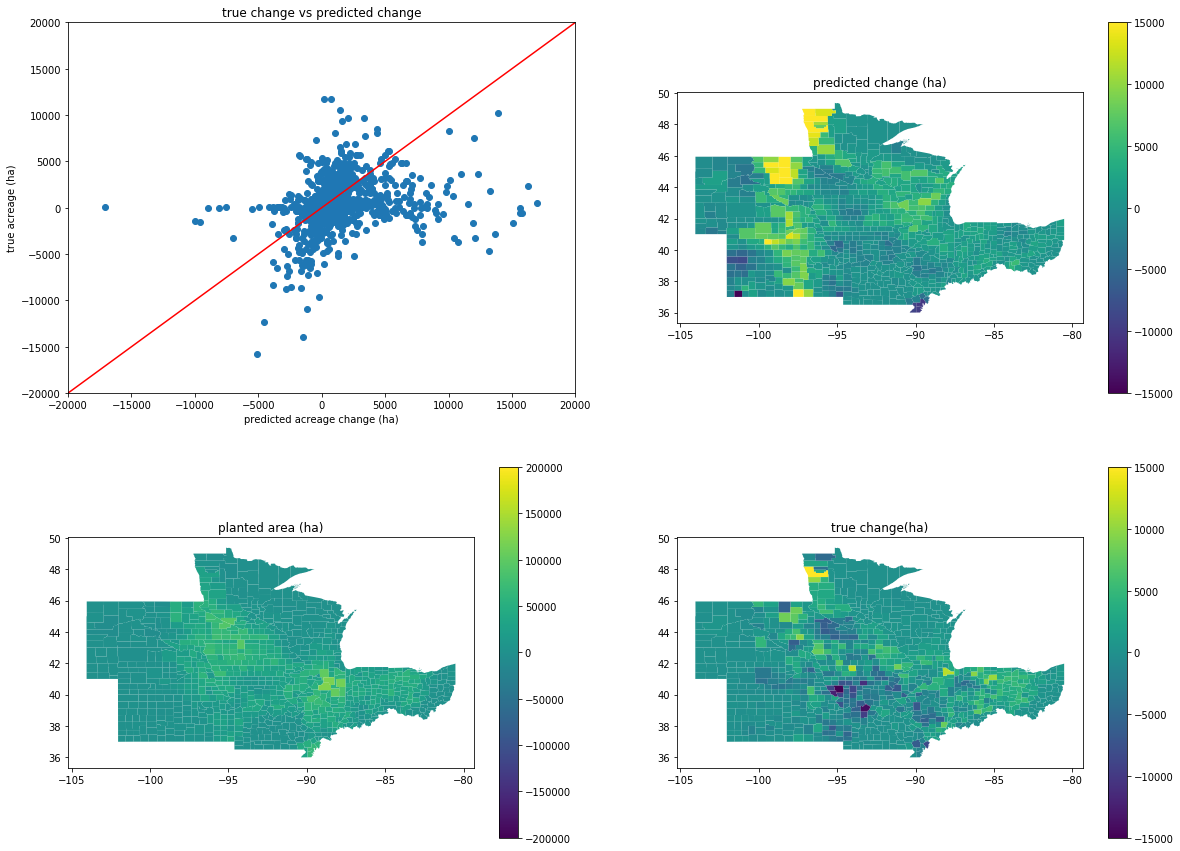

doing prediction for 1997 from 1996
our solution was 0.812683 as close as a naive extrapolation from y-1, y-2
RMSE: 207025.407816 (vs naive extrapolation RMSE of 254743.055969)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1997  corn  South Dakota         40627   265308         71158 224681             85           True
1  1997  corn          Iowa        -23498   404686         80937 428184            106          False
2  1997  corn        Kansas       -127068   141729        -21586 268798            190          False
3  1997  corn     Minnesota         82876   248282         30871 165405             67           True
4  1997  corn      Illinois        -49139    40469         60703  89608            221          False
5  1997  corn      Nebraska        105786   227910        -20893 122124             54           True
6  1997  corn      Missouri         60386   323835       -202123 263450             81           True
7  1997  corn       Indiana        -42508   -20923        162868  21584            103           True
8  1997  corn          Ohio       -107622   -60719        183359  46904             77           True
9  1997  corn     Wisconsin         38400    50461         36433  12061             24           True

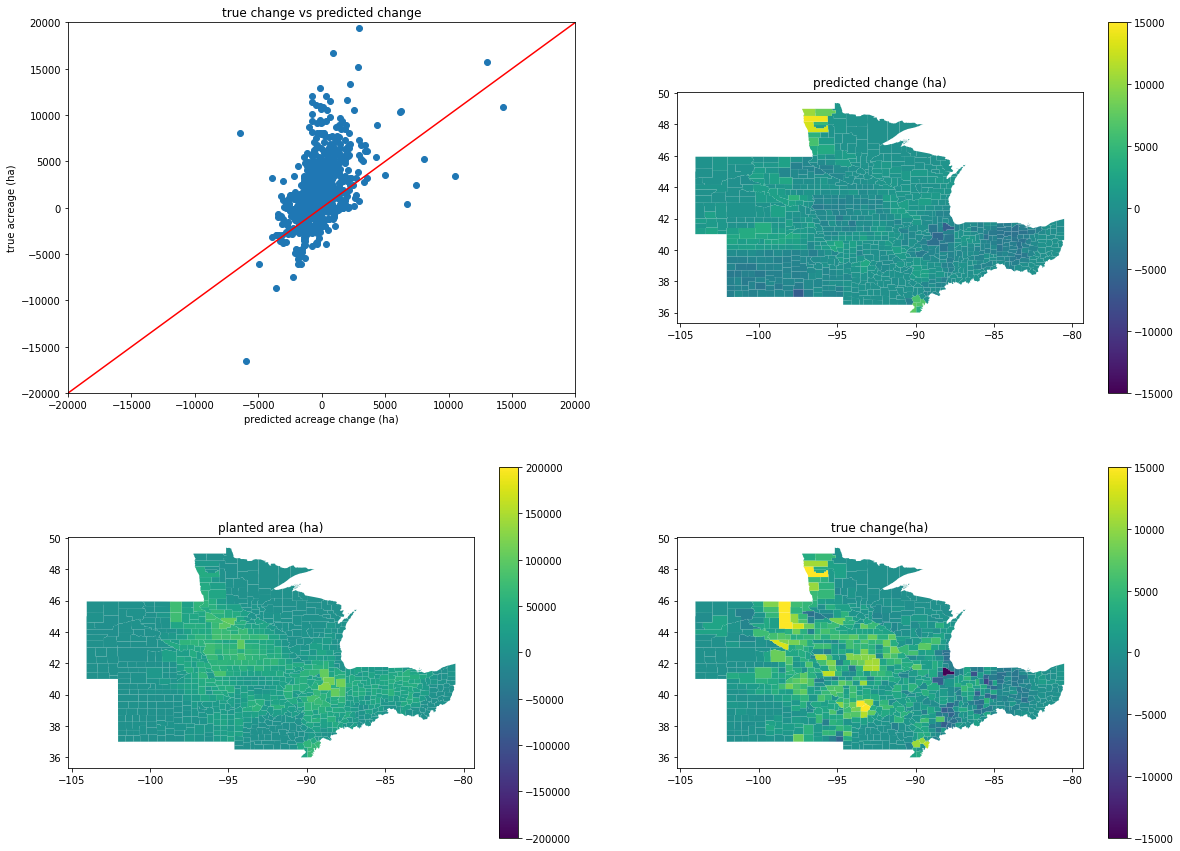

doing prediction for 1998 from 1997
our solution was 0.535531 as close as a naive extrapolation from y-1, y-2
RMSE: 108165.679665 (vs naive extrapolation RMSE of 201978.537411)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1998  corn  South Dakota        100260    53550        265308  46710             87           True
1  1998  corn          Iowa        134463   -40469        404686 174931            432          False
2  1998  corn        Kansas        252005    60703        141729 191302            315           True
3  1998  corn     Minnesota        121848   124587        248282   2740              2           True
4  1998  corn      Illinois        208957   242811         40469  33854             14           True
5  1998  corn      Nebraska        248295    80012        227910 168282            210           True
6  1998  corn      Missouri        -13270    81172        323835  94443            116          False
7  1998  corn       Indiana        141827   101292        -20923  40535             40           True
8  1998  corn          Ohio        101371    19426        -60719  81944            422           True
9  1998  corn     Wisconsin         75183    45708         50461  29475             64           True

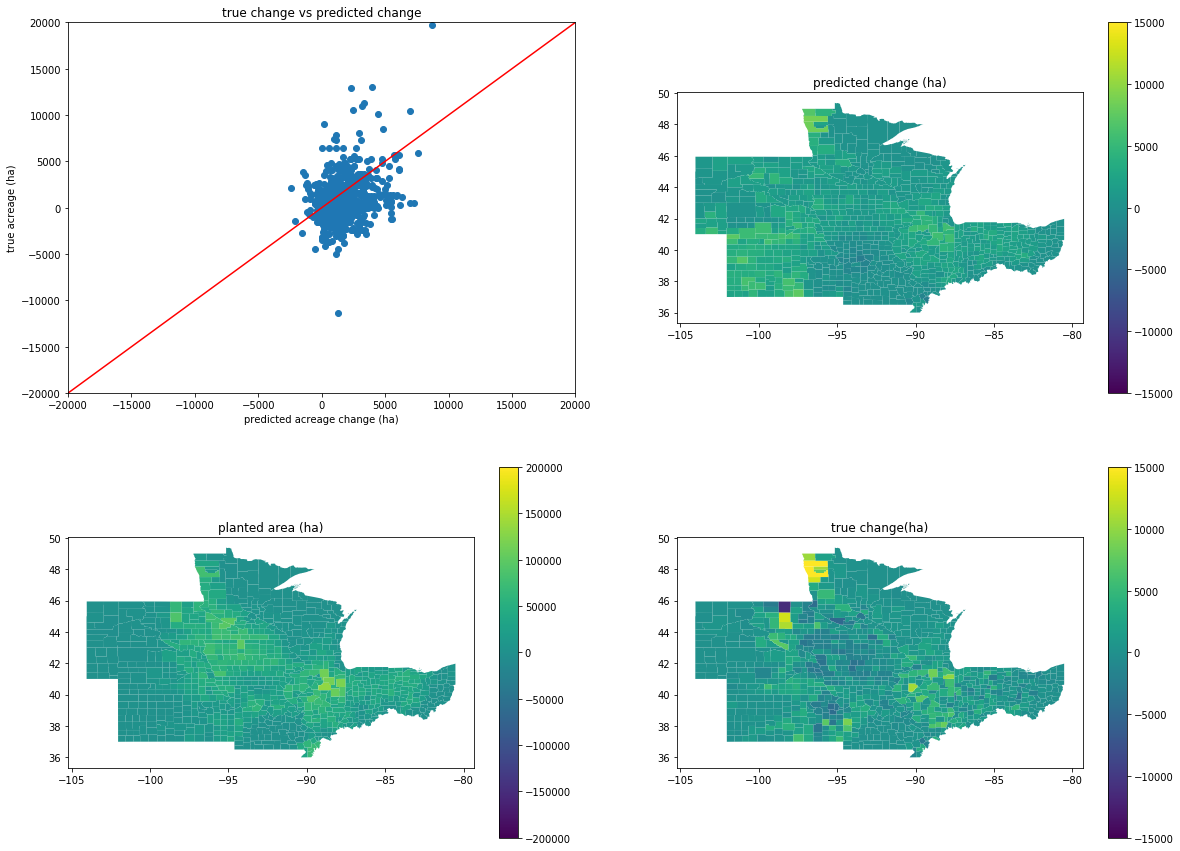

doing prediction for 1999 from 1998
our solution was 0.648965 as close as a naive extrapolation from y-1, y-2
RMSE: 88833.249526 (vs naive extrapolation RMSE of 136884.515143)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error      percent_error  sign_accurate
0  1999  corn  South Dakota        118367   265841         53550 147474                 55           True
1  1999  corn          Iowa        270568   161874        -40469 108694                 67           True
2  1999  corn        Kansas        102588   121406         60703  18818                 16           True
3  1999  corn     Minnesota        138406    42059        124587  96347                229           True
4  1999  corn      Illinois        125179       -0        242811 125179 241465733473801312          False
5  1999  corn      Nebraska        187330   202930         80012  15600                  8           True
6  1999  corn      Missouri         21669   120775         81172  99106                 82           True
7  1999  corn       Indiana         92086      809        101292  91277              11278           True
8  1999  corn          Ohio         49538    81773         19426  32235                 39           True
9  1999  corn     Wisconsin         56400    81054         45708  24654                 30           True

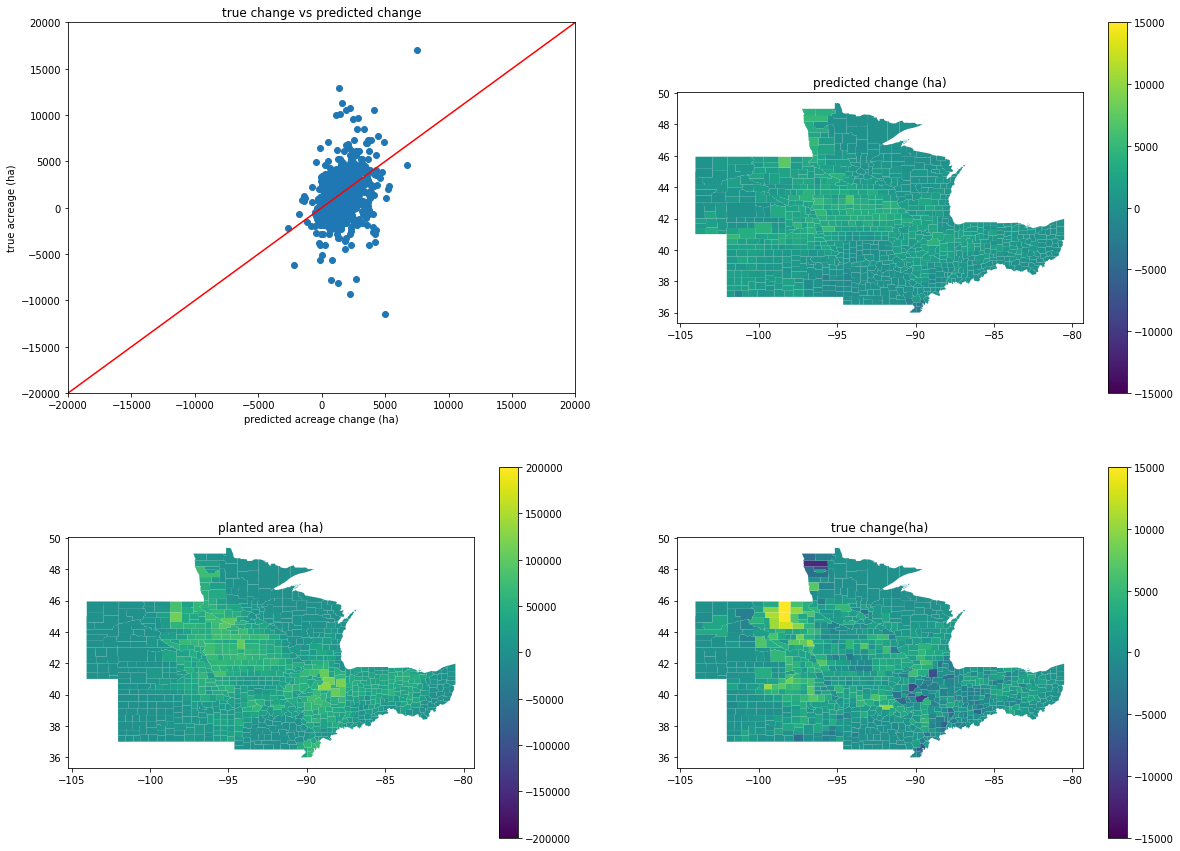

doing prediction for 2000 from 1999
our solution was 0.521701 as close as a naive extrapolation from y-1, y-2
RMSE: 64417.018947 (vs naive extrapolation RMSE of 123474.908532)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2000  corn  South Dakota         -7440   115612        265841 123051            106          False
1  2000  corn          Iowa        -39718   -40469        161874    751              2           True
2  2000  corn        Kansas         40868    40469        121406    400              1           True
3  2000  corn     Minnesota           335   120390         42059 120055            100           True
4  2000  corn      Illinois        -12410   -40469            -0  28059             69           True
5  2000  corn      Nebraska         90003   140119        202930  50116             36           True
6  2000  corn      Missouri        -79600   -99549        120775  19949             20           True
7  2000  corn       Indiana         18509   -40896           809  59405            145          False
8  2000  corn          Ohio        -43219   -61044         81773  17826             29           True
9  2000  corn     Wisconsin         13739    80045         81054  66305             83           True

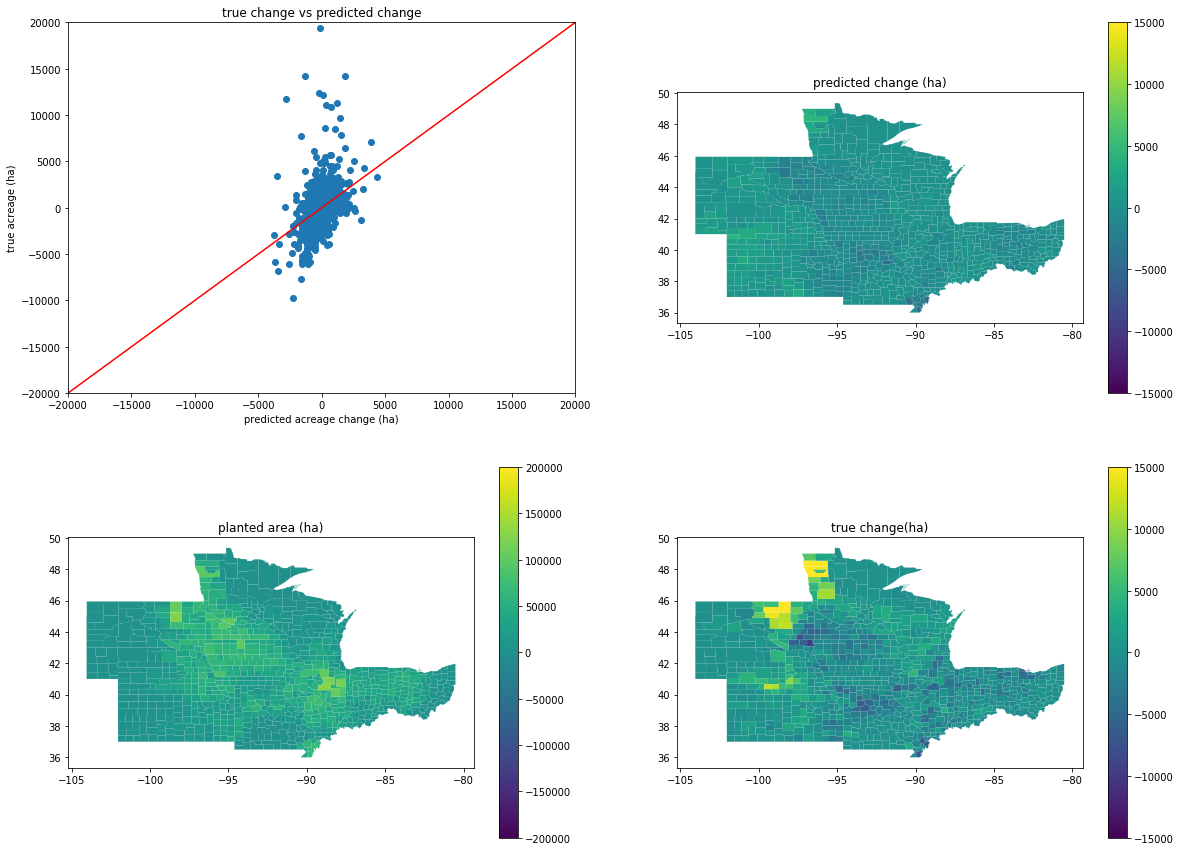

doing prediction for 2001 from 2000
our solution was 0.571525 as close as a naive extrapolation from y-1, y-2
RMSE: 55027.047049 (vs naive extrapolation RMSE of 96281.095370)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2001  corn  South Dakota         64729    42823        115612  21906             51           True
1  2001  corn          Iowa         40507   121406        -40469  80899             67           True
2  2001  corn        Kansas         79305   -38330         40469 117635            307          False
3  2001  corn     Minnesota         25203     -162        120390  25365          15670          False
4  2001  corn      Illinois         23152    80937        -40469  57785             71           True
5  2001  corn      Nebraska        118389   120758        140119   2369              2           True
6  2001  corn      Missouri        -27207   -82006        -99549  54799             67           True
7  2001  corn       Indiana         63663    40977        -40896  22686             55           True
8  2001  corn          Ohio         16523    60241        -61044  43719             73           True
9  2001  corn     Wisconsin         20361    19862         80045    499              3           True

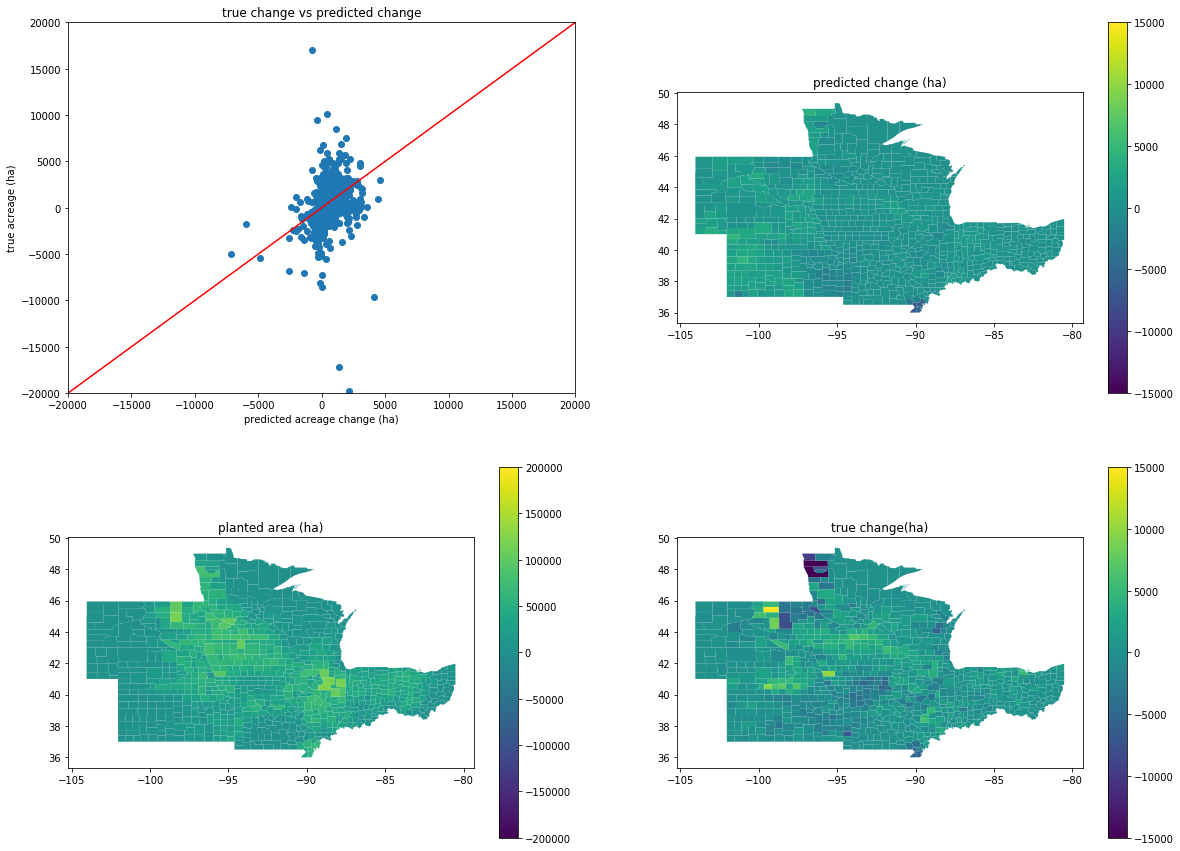

doing prediction for 2002 from 2001
our solution was 0.639805 as close as a naive extrapolation from y-1, y-2
RMSE: 95394.931211 (vs naive extrapolation RMSE of 149100.088518)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2002  corn  South Dakota        -74884   -98367         42823  23483             24           True
1  2002  corn          Iowa       -228976  -222577        121406   6399              3           True
2  2002  corn        Kansas        -17594   -41702        -38330  24108             58           True
3  2002  corn     Minnesota       -113237   -43662          -162  69575            159           True
4  2002  corn      Illinois       -220162   -40469         80937 179694            444           True
5  2002  corn      Nebraska        -44577  -100254        120758  55678             56           True
6  2002  corn      Missouri        -64179    40325        -82006 104505            259          False
7  2002  corn       Indiana        -51726    81306         40977 133032            164          False
8  2002  corn          Ohio        -83386    61164         60241 144549            236          False
9  2002  corn     Wisconsin        -15309   -24499         19862   9190             38           True

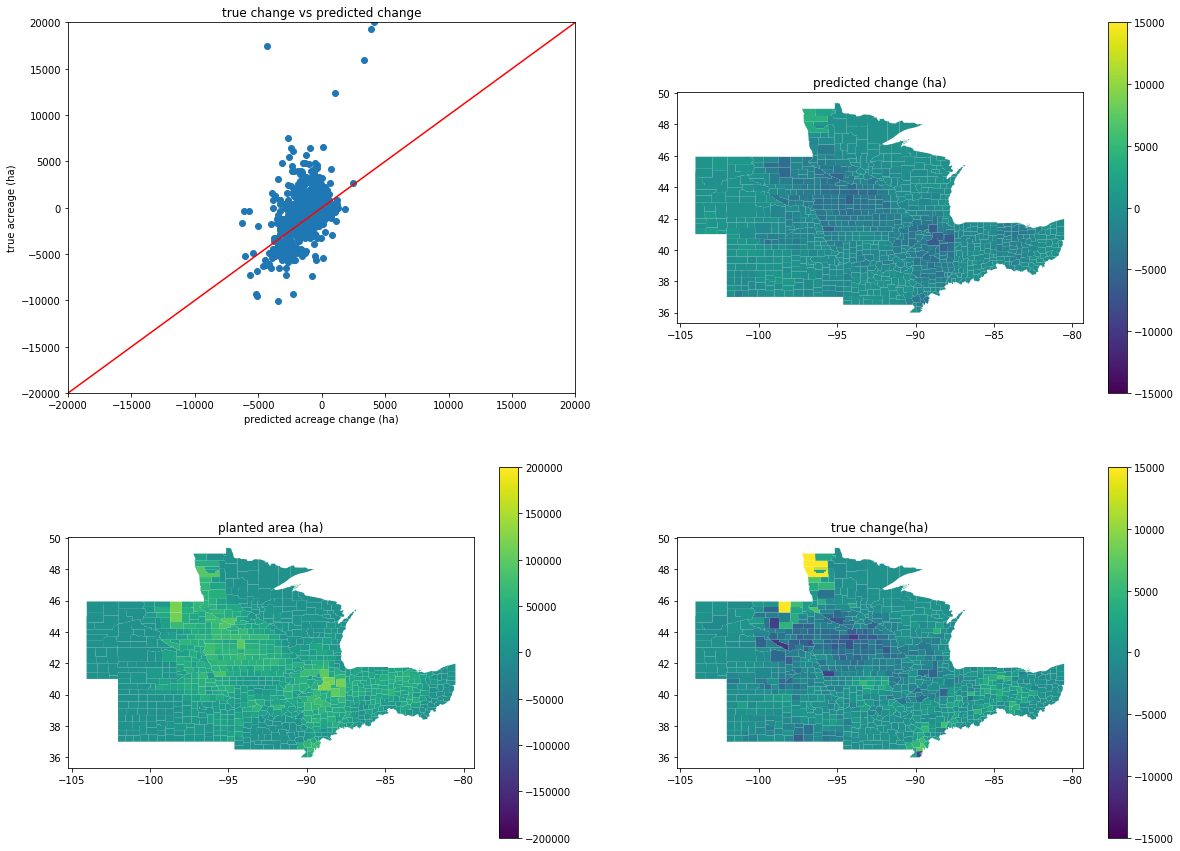

doing prediction for 2003 from 2002
our solution was 0.693048 as close as a naive extrapolation from y-1, y-2
RMSE: 109200.882522 (vs naive extrapolation RMSE of 157566.192250)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2003  corn  South Dakota         49572     1294        -98367  48278           3732           True
1  2003  corn          Iowa         -2089    60703       -222577  62792            103          False
2  2003  corn        Kansas        -16423   -59532        -41702  43109             72           True
3  2003  corn     Minnesota         14204   121148        -43662 106944             88           True
4  2003  corn      Illinois          8329  -121406        -40469 129735            107          False
5  2003  corn      Nebraska         59896   -59590       -100254 119486            201          False
6  2003  corn      Missouri         32916   -19126         40325  52042            272          False
7  2003  corn       Indiana         17392  -143297         81306 160689            112          False
8  2003  corn          Ohio         11402  -181980         61164 193382            106          False
9  2003  corn     Wisconsin         20541    71974        -24499  51432             71           True

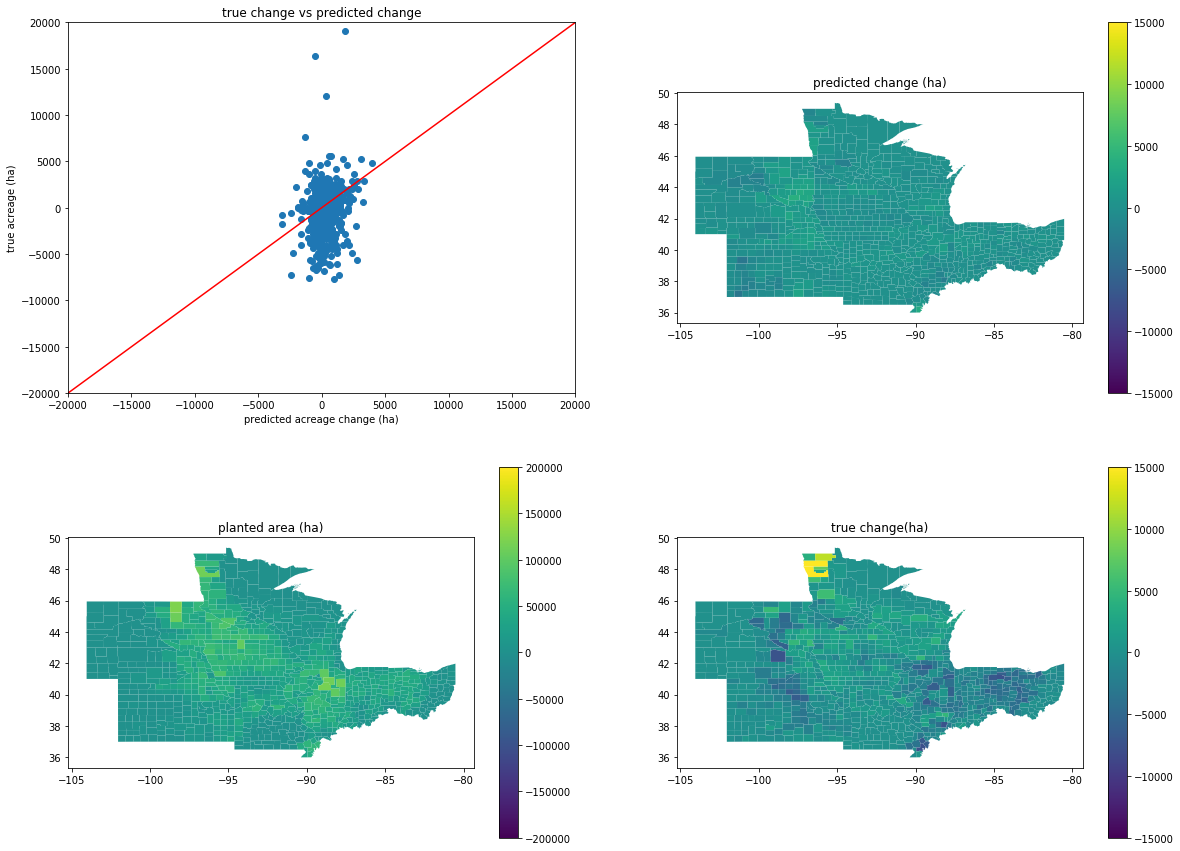

doing prediction for 2004 from 2003
our solution was 0.404493 as close as a naive extrapolation from y-1, y-2
RMSE: 63215.061506 (vs naive extrapolation RMSE of 156282.328966)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2004  corn  South Dakota         10097   -44438          1294  54534            123          False
1  2004  corn          Iowa       -303802  -161874         60703 141928             88           True
2  2004  corn        Kansas         43235    72105        -59532  28870             40           True
3  2004  corn     Minnesota       -125424   -82714        121148  42710             52           True
4  2004  corn      Illinois       -185480  -141640       -121406  43840             31           True
5  2004  corn      Nebraska         10112    99910        -59590  89798             90           True
6  2004  corn      Missouri        -23987    -1931        -19126  22056           1142           True
7  2004  corn       Indiana         17285    41705       -143297  24420             59           True
8  2004  corn          Ohio         14723    60579       -181980  45855             76           True
9  2004  corn     Wisconsin        -16648   -48508         71974  31861             66           True

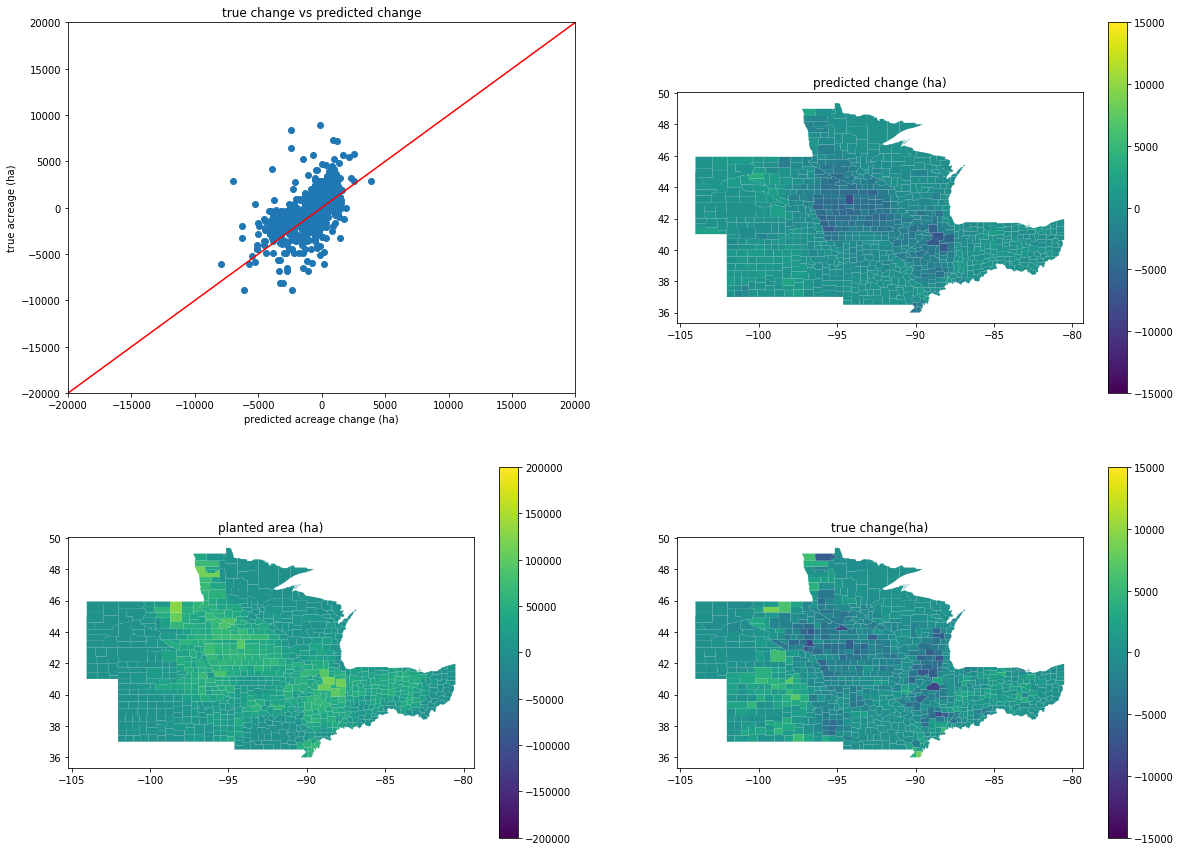

doing prediction for 2005 from 2004
our solution was 0.878167 as close as a naive extrapolation from y-1, y-2
RMSE: 66215.399428 (vs naive extrapolation RMSE of 75401.801344)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2005  corn  South Dakota         19639  -100356        -44438 119995            120          False
1  2005  corn          Iowa        -97164   -60703       -161874  36461             60           True
2  2005  corn        Kansas         62375    49455         72105  12919             26           True
3  2005  corn     Minnesota       -118213  -161947        -82714  43734             27           True
4  2005  corn      Illinois        -63544  -182109       -141640 118565             65           True
5  2005  corn      Nebraska         23261   -40169         99910  63430            158          False
6  2005  corn      Missouri        -28376   -20168         -1931   8207             41           True
7  2005  corn       Indiana        -16841   -61586         41705  44745             73           True
8  2005  corn          Ohio        -50784    19934         60579  70718            355          False
9  2005  corn     Wisconsin         34047     4289        -48508  29758            694           True

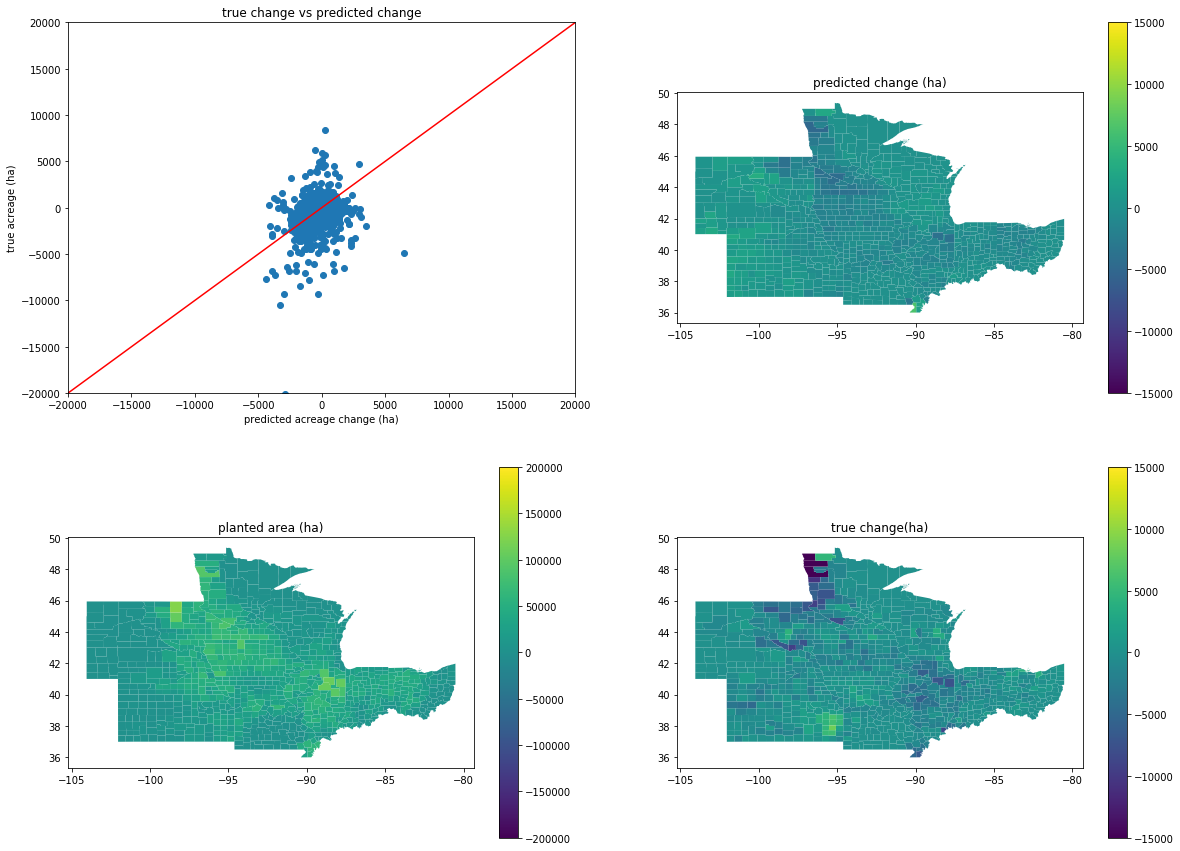

doing prediction for 2006 from 2005
our solution was 0.875132 as close as a naive extrapolation from y-1, y-2
RMSE: 176464.199869 (vs naive extrapolation RMSE of 201642.938709)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2006  corn  South Dakota        -32994    23637       -100356  56631            240          False
1  2006  corn          Iowa       -148104    40469        -60703 188573            466          False
2  2006  corn        Kansas        -13018   101862         49455 114880            113          False
3  2006  corn     Minnesota       -117411   182009       -161947 299420            165          False
4  2006  corn      Illinois        -62584   242811       -182109 305395            126          False
5  2006  corn      Nebraska        -35463   141426        -40169 176889            125          False
6  2006  corn      Missouri        -34286    82683        -20168 116970            141          False
7  2006  corn       Indiana        -17680   122728        -61586 140408            114          False
8  2006  corn          Ohio        -34138    61352         19934  95490            156          False
9  2006  corn     Wisconsin        -36027    16021          4289  52048            325          False

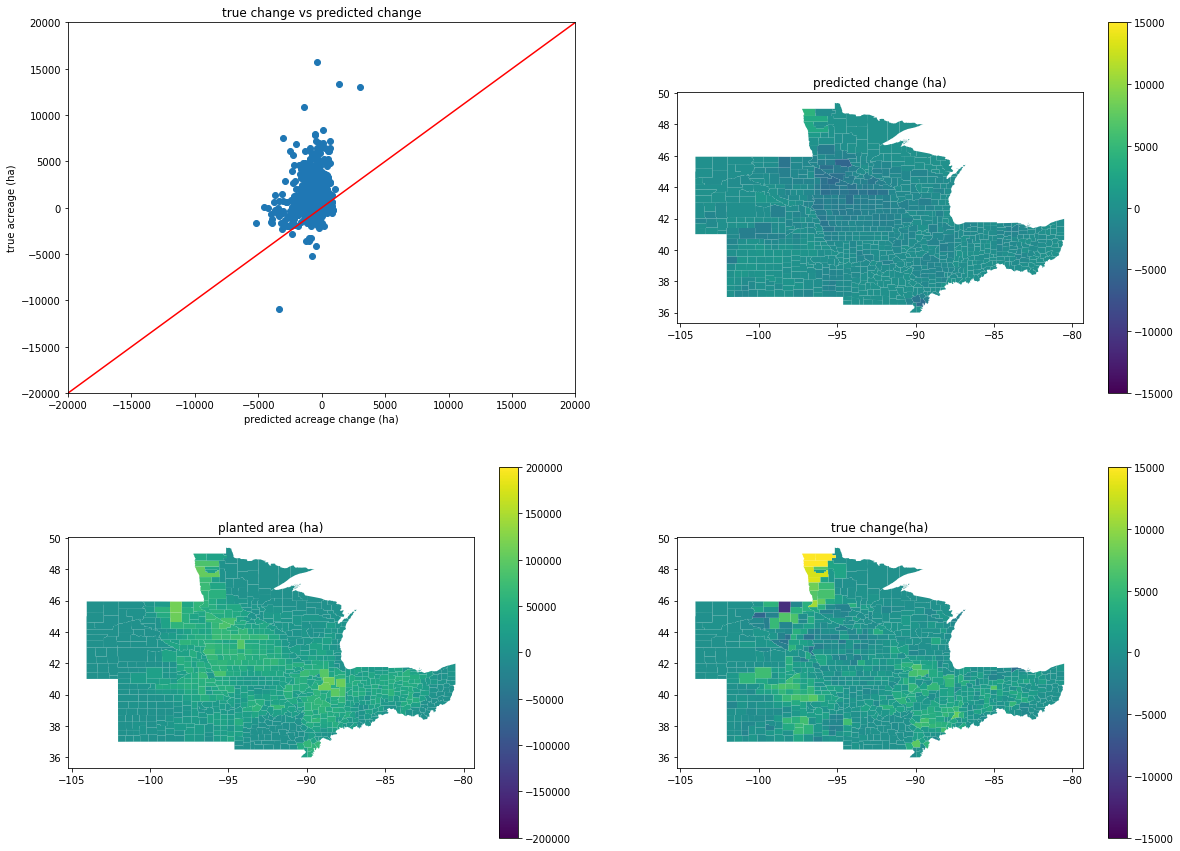

doing prediction for 2007 from 2006
our solution was 0.611814 as close as a naive extrapolation from y-1, y-2
RMSE: 315727.608393 (vs naive extrapolation RMSE of 516051.890378)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2007  corn  South Dakota        -19603  -286580         23637 266977             93           True
1  2007  corn          Iowa       -136934  -607028         40469 470094             77           True
2  2007  corn        Kansas        -52297  -201940        101862 149643             74           True
3  2007  corn     Minnesota       -101154  -413583        182009 312429             76           True
4  2007  corn      Illinois       -196859  -728434        242811 531576             73           True
5  2007  corn      Nebraska        -69472  -477236        141426 407764             85           True
6  2007  corn      Missouri        -40180  -182761         82683 142581             78           True
7  2007  corn       Indiana        -60236  -367495        122728 307259             84           True
8  2007  corn          Ohio        -36199  -162796         61352 126597             78           True
9  2007  corn     Wisconsin        -29741  -100172         16021  70431             70           True

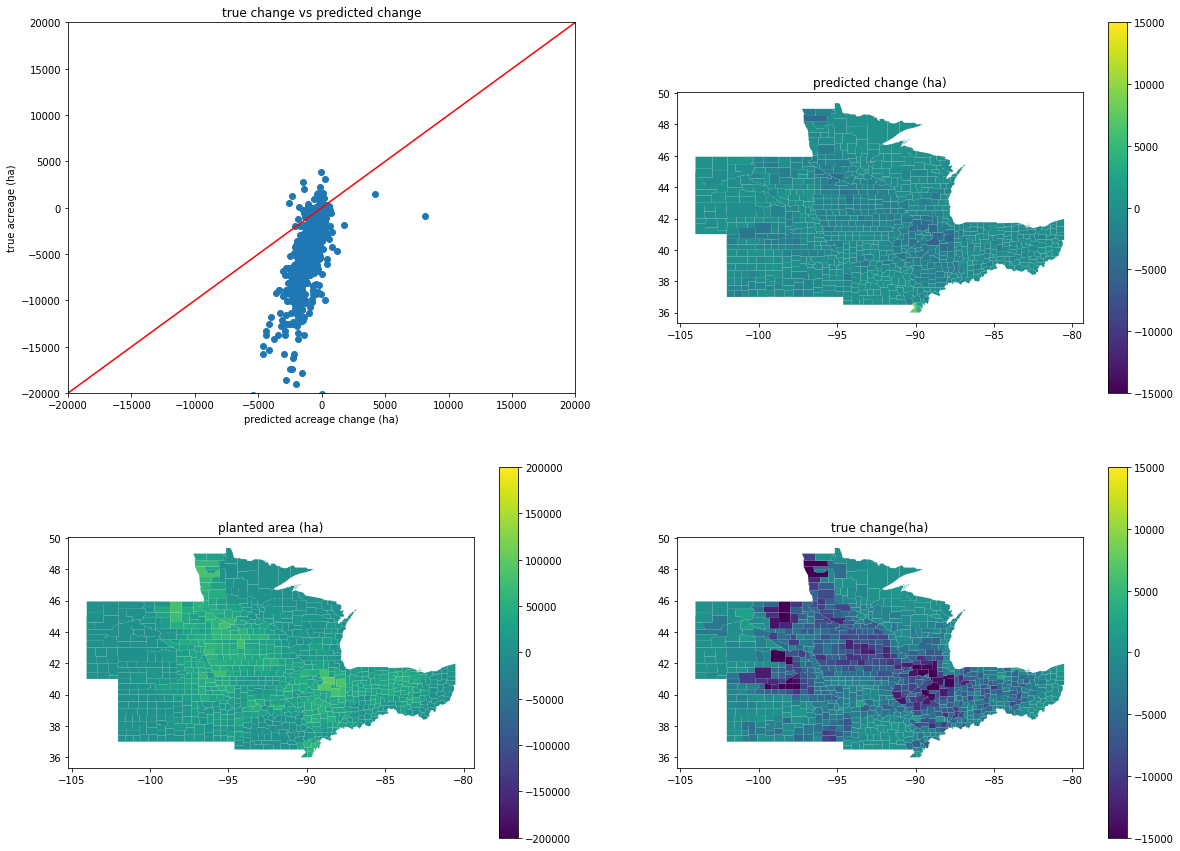

doing prediction for 2008 from 2007
our solution was 0.218745 as close as a naive extrapolation from y-1, y-2
RMSE: 152530.326005 (vs naive extrapolation RMSE of 697298.730399)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2008  corn  South Dakota        120412   356023       -286580 235610             66           True
1  2008  corn          Iowa        365226   445154       -607028  79928             18           True
2  2008  corn        Kansas       -113555   253022       -201940 366577            145          False
3  2008  corn     Minnesota        228043   284316       -413583  56273             20           True
4  2008  corn      Illinois        349324   364889       -728434  15565              4           True
5  2008  corn      Nebraska        266720   416948       -477236 150228             36           True
6  2008  corn      Missouri        108467   202140       -182761  93674             46           True
7  2008  corn       Indiana        239370   265578       -367495  26208             10           True
8  2008  corn          Ohio        132893   103353       -162796  29541             29           True
9  2008  corn     Wisconsin         90849    82832       -100172   8017             10           True

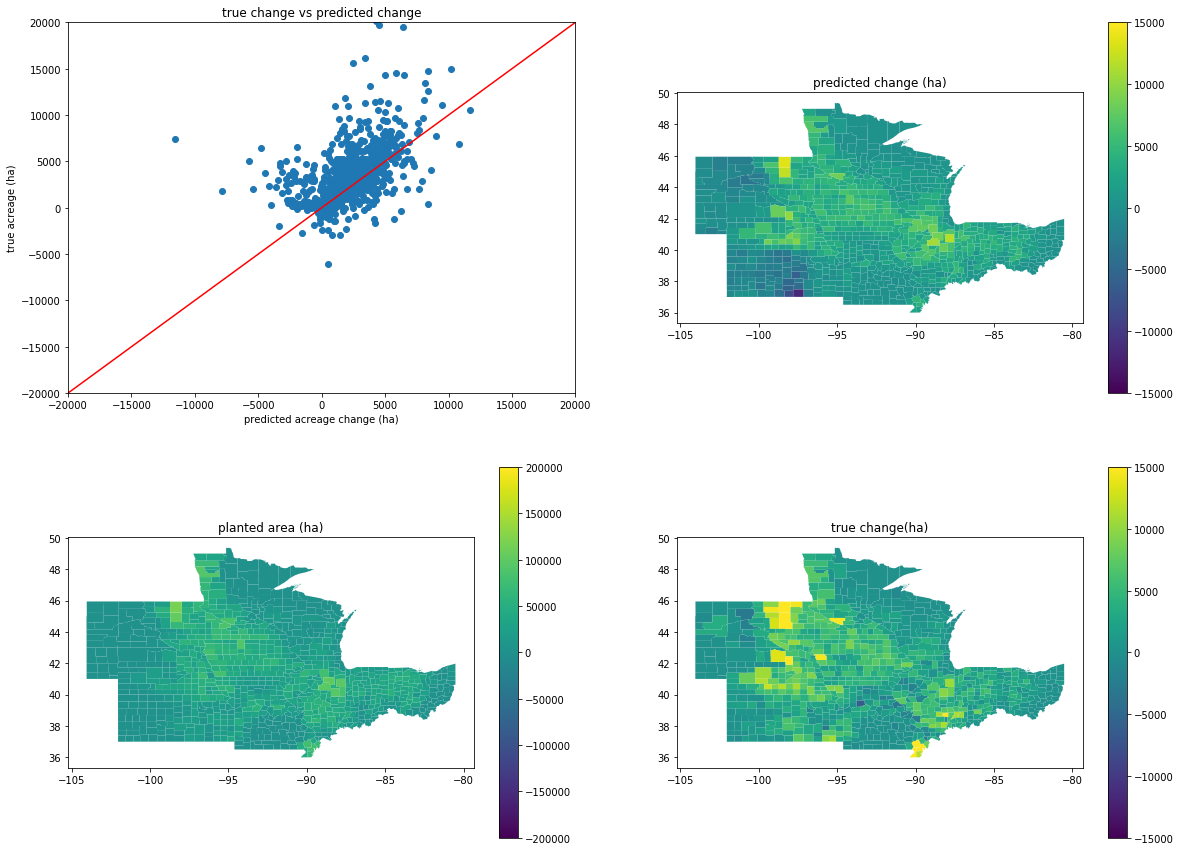

doing prediction for 2009 from 2008
our solution was 1.942815 as close as a naive extrapolation from y-1, y-2
RMSE: 547072.676269 (vs naive extrapolation RMSE of 281587.575293)


year  crop    state_name  predicted_dy  true_dy  last_year_dy   error  percent_error  sign_accurate
0  2009  corn  South Dakota        365210    58995        356023  306214            519           True
1  2009  corn          Iowa        957675   -60703        445154 1018378           1678          False
2  2009  corn        Kansas        354628   171960        253022  182668            106           True
3  2009  corn     Minnesota        623089    63448        284316  559641            882           True
4  2009  corn      Illinois        895511    81075        364889  814435           1005           True
5  2009  corn      Nebraska        586294   -40453        416948  626747           1549          False
6  2009  corn      Missouri        340672    60446        202140  280227            464           True
7  2009  corn       Indiana        463219     -324        265578  463542         143180          False
8  2009  corn          Ohio        338976    17333        103353  321643           1856           True
9  2009  corn     Wisconsin        258652     8673         82832  249979           2882           True

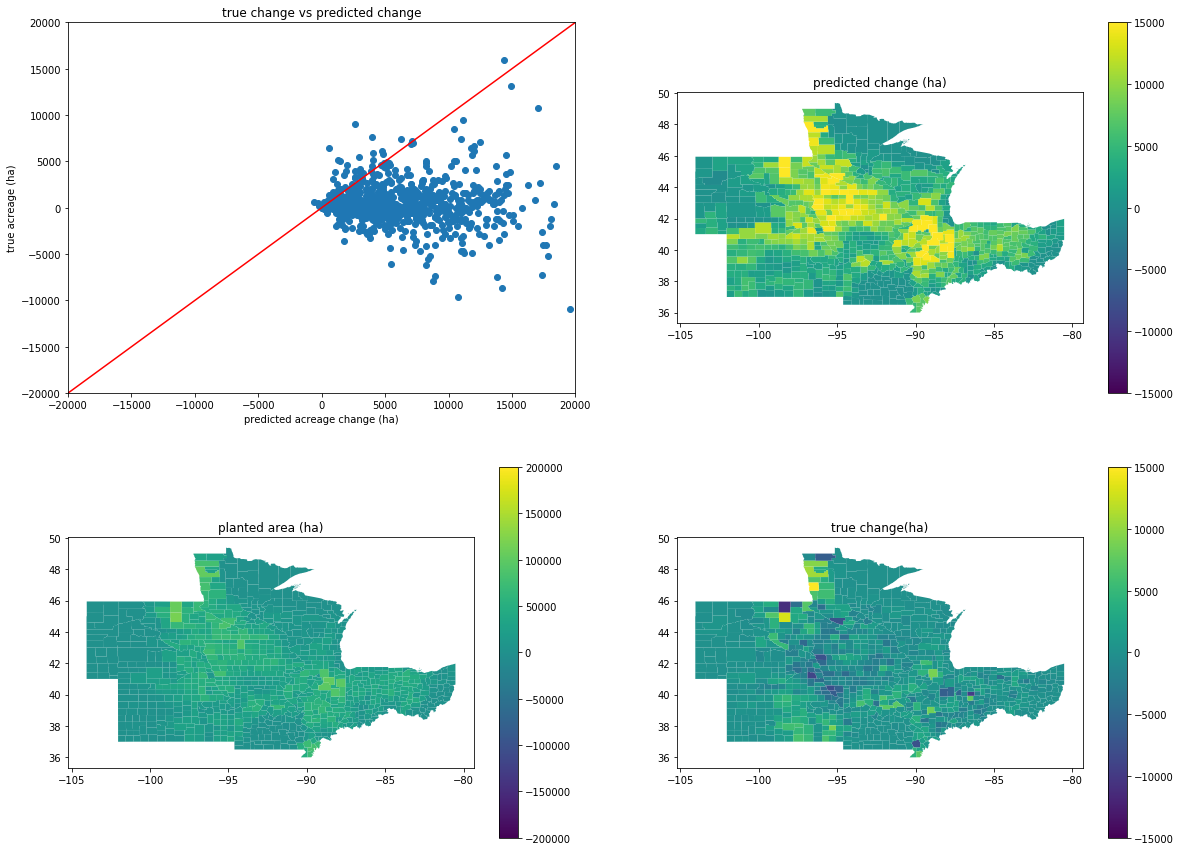

doing prediction for 2010 from 2009
our solution was 1.084609 as close as a naive extrapolation from y-1, y-2
RMSE: 123614.036324 (vs naive extrapolation RMSE of 113971.034066)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2010  corn  South Dakota         21304   -30570         58995  51874            170          False
1  2010  corn          Iowa         95807    80937        -60703  14870             18           True
2  2010  corn        Kansas        -42076   250148        171960 292224            117          False
3  2010  corn     Minnesota        -34933    80473         63448 115406            143          False
4  2010  corn      Illinois         17772  -120315         81075 138087            115          False
5  2010  corn      Nebraska         91195   140535        -40453  49340             35           True
6  2010  corn      Missouri         59724   -82583         60446 142307            172          False
7  2010  corn       Indiana         55272   -40503          -324  95774            236          False
8  2010  corn          Ohio         35736    19904         17333  15832             80           True
9  2010  corn     Wisconsin          6316     4920          8673   1396             28           True

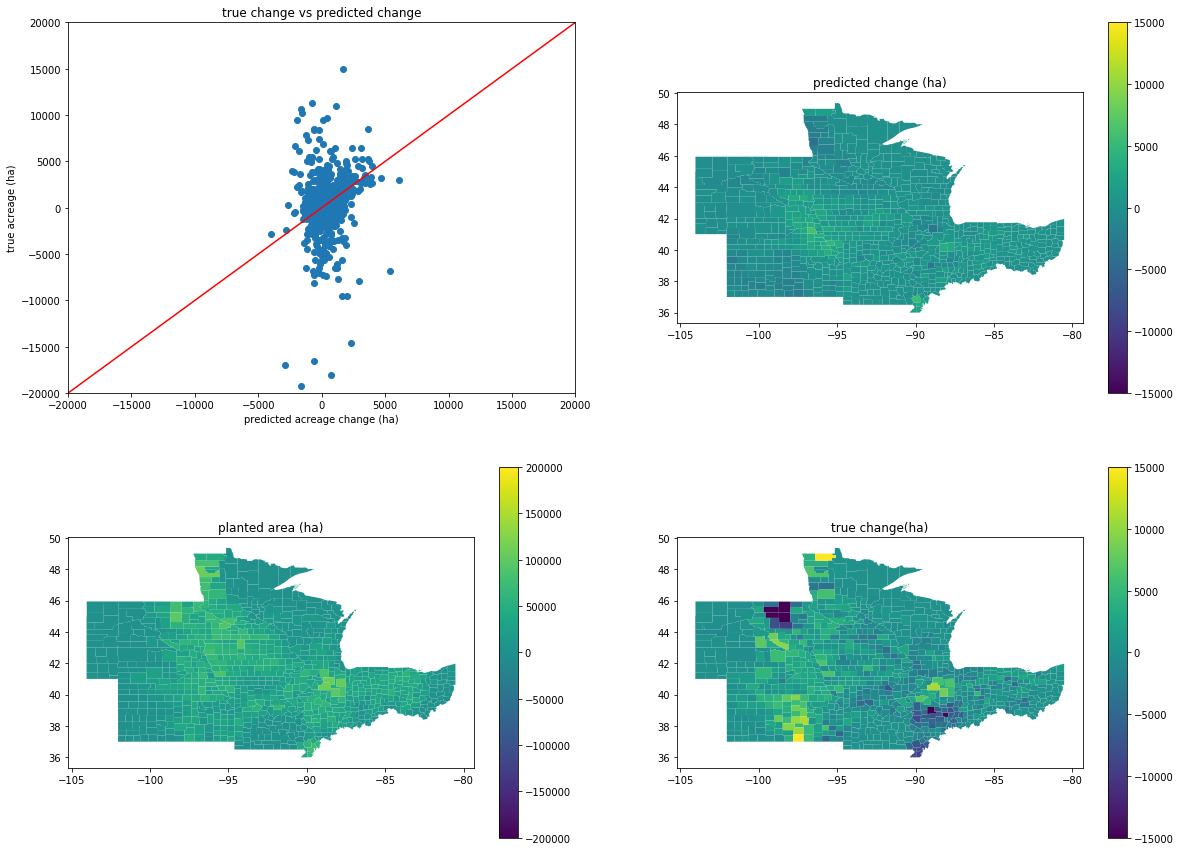

doing prediction for 2011 from 2010
our solution was 1.375112 as close as a naive extrapolation from y-1, y-2
RMSE: 254041.059542 (vs naive extrapolation RMSE of 184742.123366)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2011  corn  South Dakota       -241673   -45639        -30570 196034            430           True
1  2011  corn          Iowa       -686736  -182109         80937 504628            277           True
2  2011  corn        Kansas         29044  -122138        250148 151182            124          False
3  2011  corn     Minnesota       -416503  -125336         80473 291167            232           True
4  2011  corn      Illinois       -292835   -59647       -120315 233188            391           True
5  2011  corn      Nebraska       -469332  -102425        140535 366907            358           True
6  2011  corn      Missouri        -18737    77022        -82583  95759            124          False
7  2011  corn       Indiana       -131853   -13155        -40503 118698            902           True
8  2011  corn          Ohio        -81805   -22517         19904  59288            263           True
9  2011  corn     Wisconsin       -178864    -8911          4920 169953           1907           True

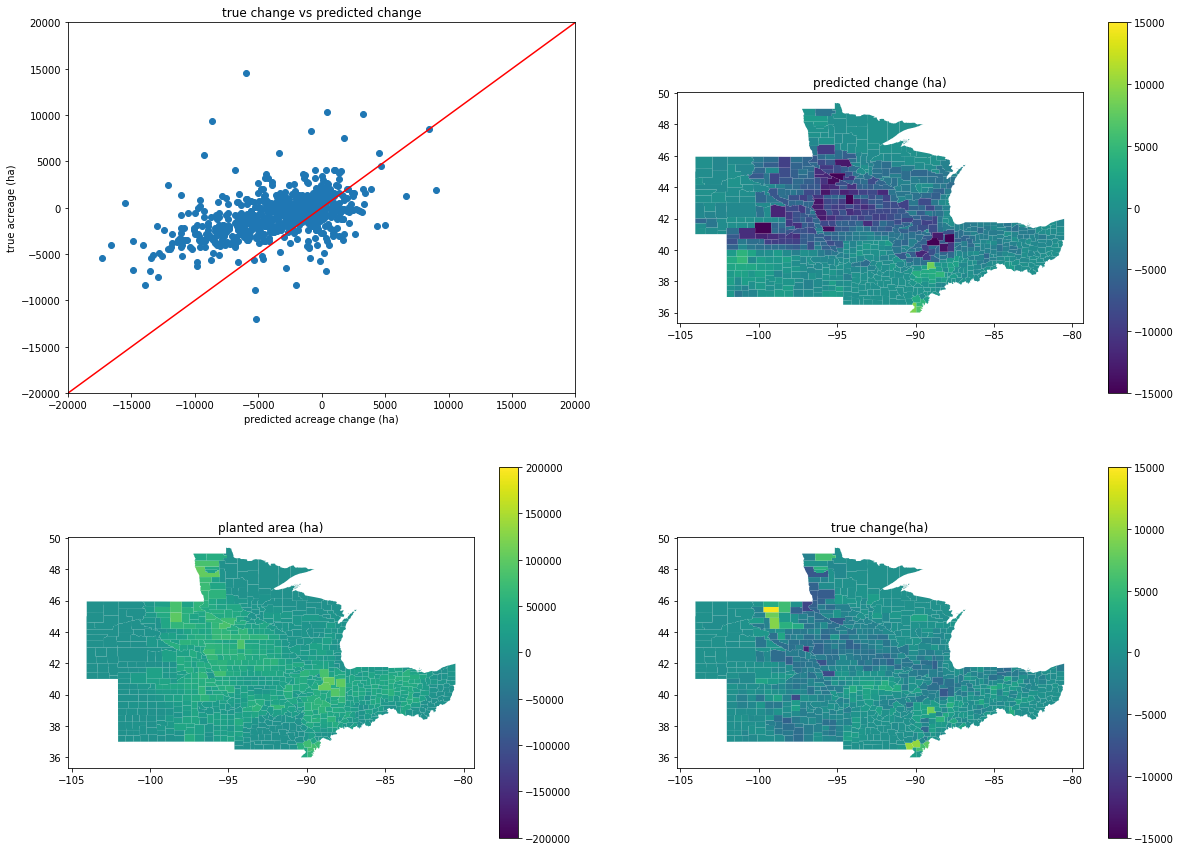

doing prediction for 2012 from 2011
our solution was 1.143285 as close as a naive extrapolation from y-1, y-2
RMSE: 160178.574063 (vs naive extrapolation RMSE of 140103.857045)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error      percent_error  sign_accurate
0  2012  corn  South Dakota        -46174   258702        -45639 304876                118          False
1  2012  corn          Iowa       -179432       -0       -182109 179432 274010367166056064           True
2  2012  corn        Kansas        -39819     5606       -122138  45425                810          False
3  2012  corn     Minnesota       -199183   -34732       -125336 164451                473           True
4  2012  corn      Illinois       -202163    37513        -59647 239676                639          False
5  2012  corn      Nebraska         41390    61120       -102425  19730                 32           True
6  2012  corn      Missouri       -110321    20248         77022 130570                645          False
7  2012  corn       Indiana       -115264   -62088        -13155  53176                 86           True
8  2012  corn          Ohio       -117020    24325        -22517 141345                581          False
9  2012  corn     Wisconsin        -32486    35563         -8911  68050                191          False

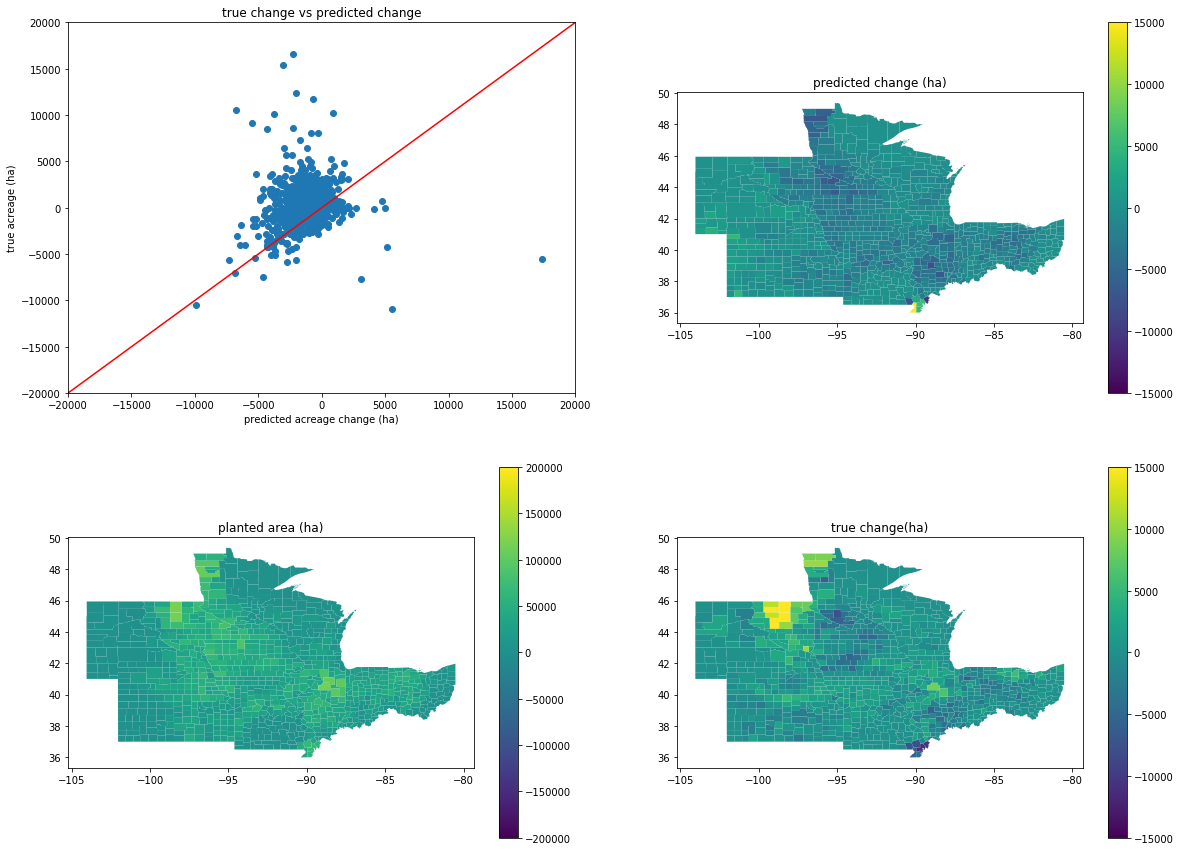

doing prediction for 2013 from 2012
our solution was 0.795838 as close as a naive extrapolation from y-1, y-2
RMSE: 112799.604947 (vs naive extrapolation RMSE of 141736.949789)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2013  corn  South Dakota           529   -48637        258702  49166            101          False
1  2013  corn          Iowa       -165107   -20234            -0 144872            716           True
2  2013  corn        Kansas        -43137  -153626          5606 110488             72           True
3  2013  corn     Minnesota         -4912  -133484        -34732 128572             96           True
4  2013  corn      Illinois        -23546   182139         37513 205685            113          False
5  2013  corn      Nebraska       -164517  -102543         61120  61974             60           True
6  2013  corn      Missouri         64220   100844         20248  36624             36           True
7  2013  corn       Indiana         92564     6057        -62088  86507           1428           True
8  2013  corn          Ohio         97762   -44038         24325 141800            322          False
9  2013  corn     Wisconsin        -46635   -50492         35563   3856              8           True

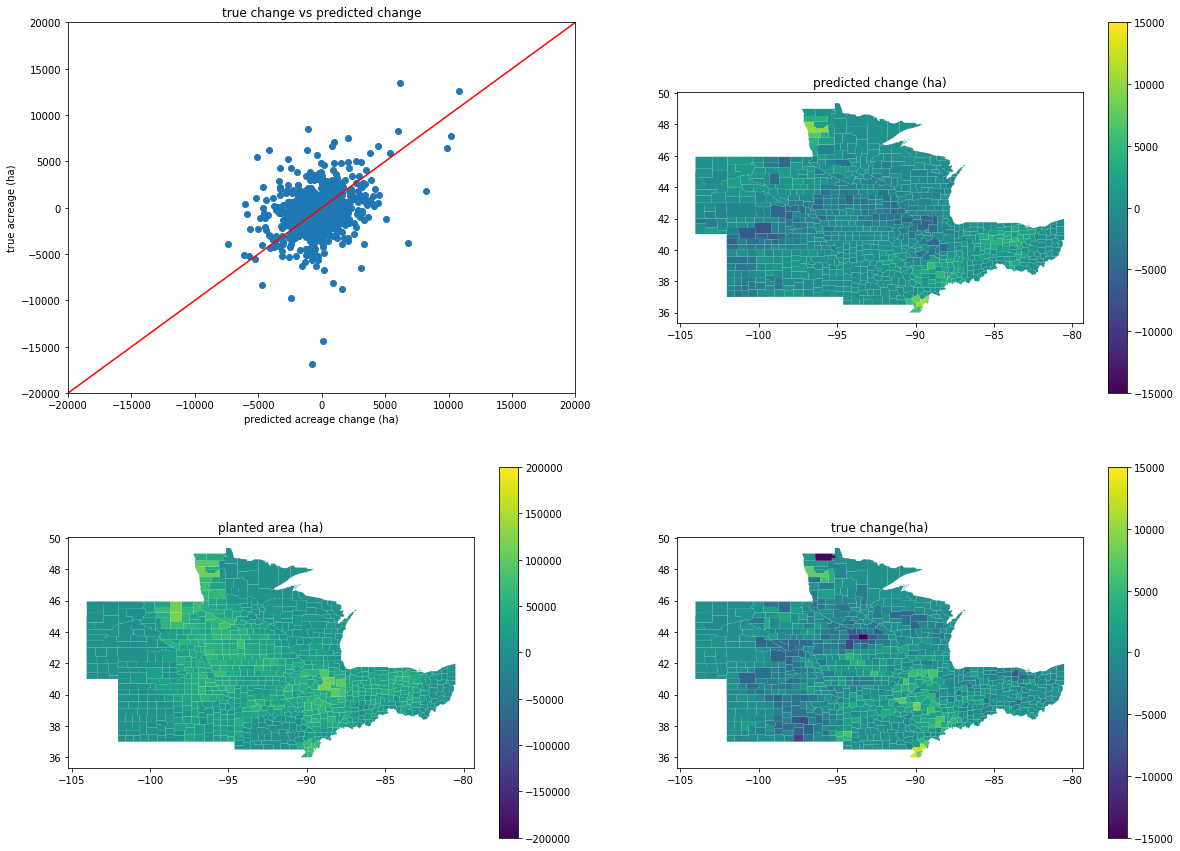

doing prediction for 2014 from 2013
our solution was 1.312461 as close as a naive extrapolation from y-1, y-2
RMSE: 310587.244520 (vs naive extrapolation RMSE of 236644.983723)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2014  corn  South Dakota        442962   206454        -48637 236508            115           True
1  2014  corn          Iowa        746498   222577        -20234 523921            235           True
2  2014  corn        Kansas        346122   162201       -153626 183921            113           True
3  2014  corn     Minnesota        504417   260352       -133484 244066             94           True
4  2014  corn      Illinois        589233   122362        182139 466872            382           True
5  2014  corn      Nebraska        689167   243387       -102543 445780            183           True
6  2014  corn      Missouri         81998   -16509        100844  98506            597          False
7  2014  corn       Indiana        348728   106814          6057 241915            226           True
8  2014  corn          Ohio        227103    81775        -44038 145328            178           True
9  2014  corn     Wisconsin        270676    84169        -50492 186507            222           True

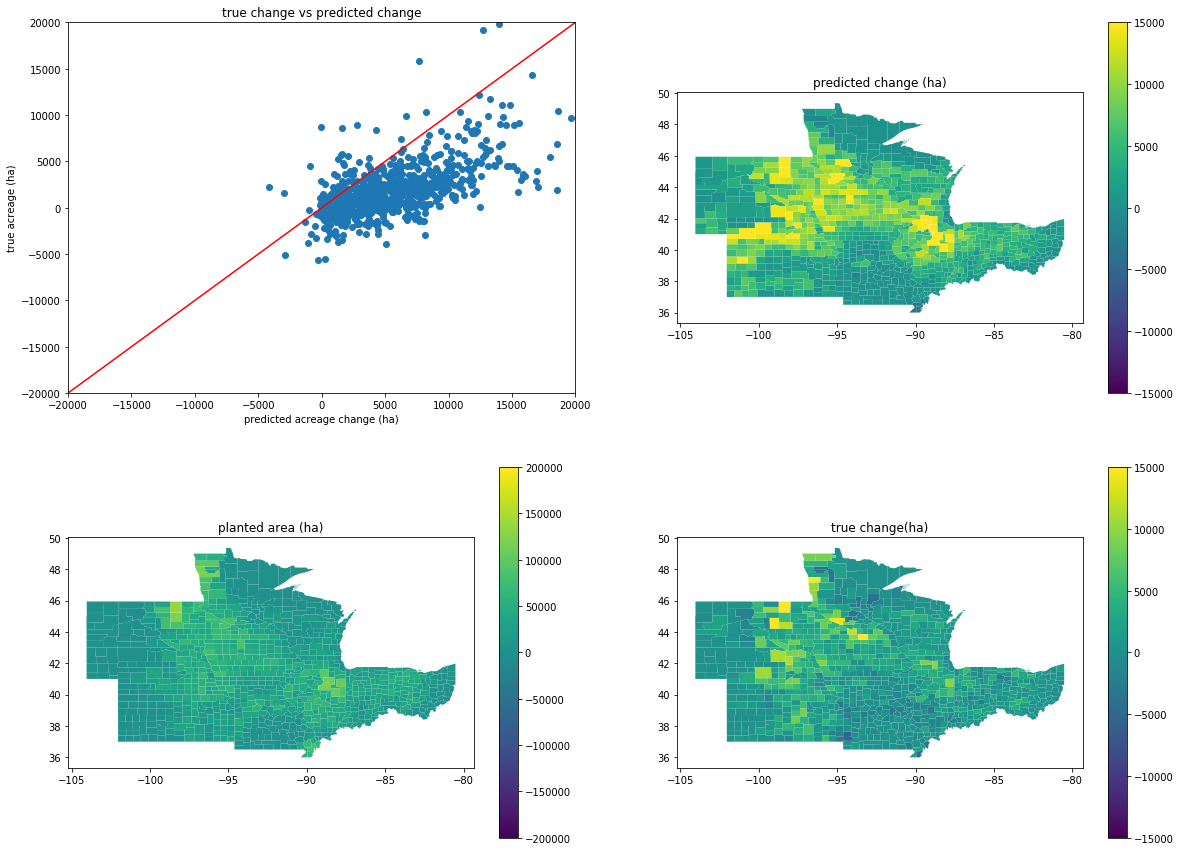

doing prediction for 2015 from 2014
our solution was 0.680579 as close as a naive extrapolation from y-1, y-2
RMSE: 129979.396343 (vs naive extrapolation RMSE of 190983.586844)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2015  corn  South Dakota         56249    18082        206454  38166            211           True
1  2015  corn          Iowa          5294     -458        222577   5753           1255          False
2  2015  corn        Kansas        107554   -24007        162201 131561            548          False
3  2015  corn     Minnesota        -47560   108146        260352 155706            144          False
4  2015  corn      Illinois        -45171    -2547        122362  42625           1674           True
5  2015  corn      Nebraska         37106   -43907        243387  81013            185          False
6  2015  corn      Missouri        -10809  -352061        -16509 341252             97           True
7  2015  corn       Indiana         25177    38234        106814  13057             34           True
8  2015  corn          Ohio          9104    19033         81775   9929             52           True
9  2015  corn     Wisconsin          7859    36175         84169  28317             78           True

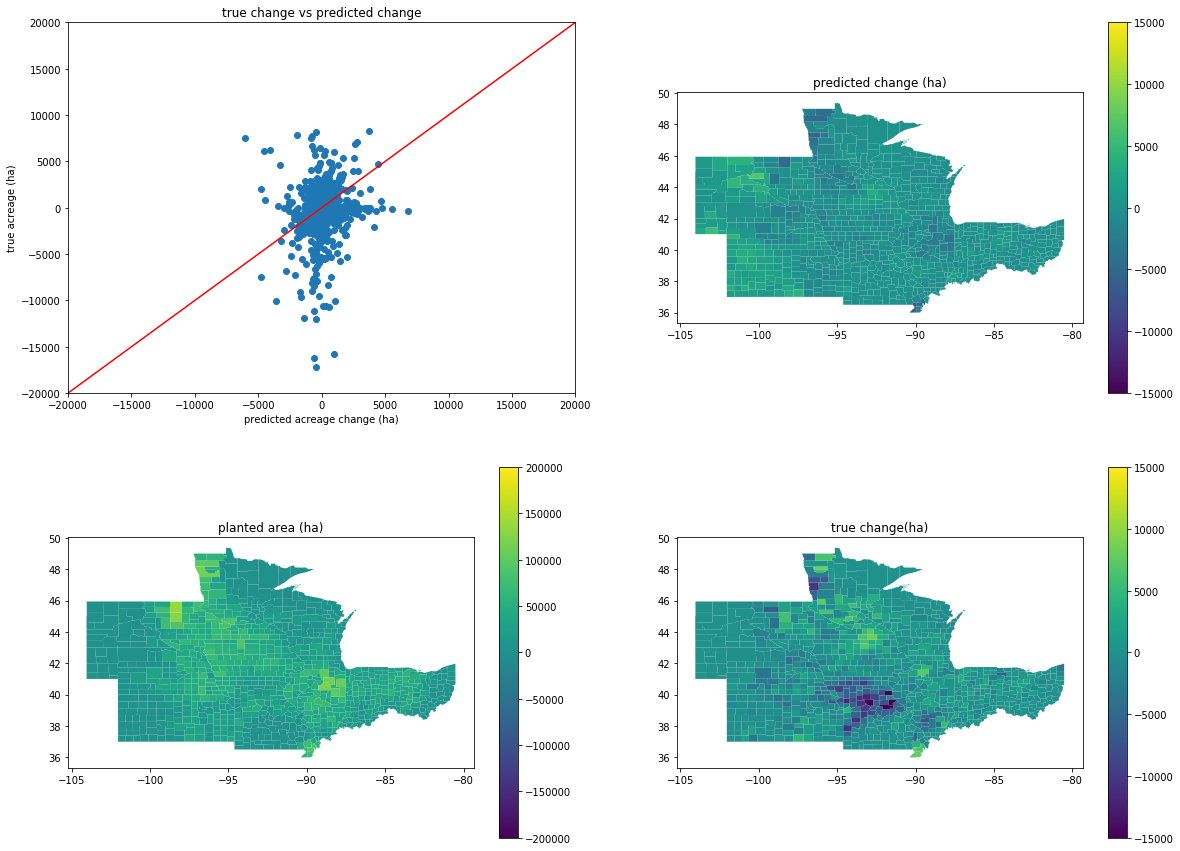

doing prediction for 2016 from 2015
our solution was 0.641824 as close as a naive extrapolation from y-1, y-2
RMSE: 147313.393200 (vs naive extrapolation RMSE of 229523.146531)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2016  corn  South Dakota        -48689   -13506         18082  35183            260           True
1  2016  corn          Iowa       -186513  -141182          -458  45331             32           True
2  2016  corn        Kansas         10854    66817        -24007  55962             84           True
3  2016  corn     Minnesota       -164582   -35015        108146 129567            370           True
4  2016  corn      Illinois       -110312   117050         -2547 227362            194          False
5  2016  corn      Nebraska         -6439   -43729        -43907  37290             85           True
6  2016  corn      Missouri        -20676   327938       -352061 348614            106          False
7  2016  corn       Indiana        -48524    43135         38234  91658            212          False
8  2016  corn          Ohio        -31063    41324         19033  72387            175          False
9  2016  corn     Wisconsin        -44588    29867         36175  74455            249          False

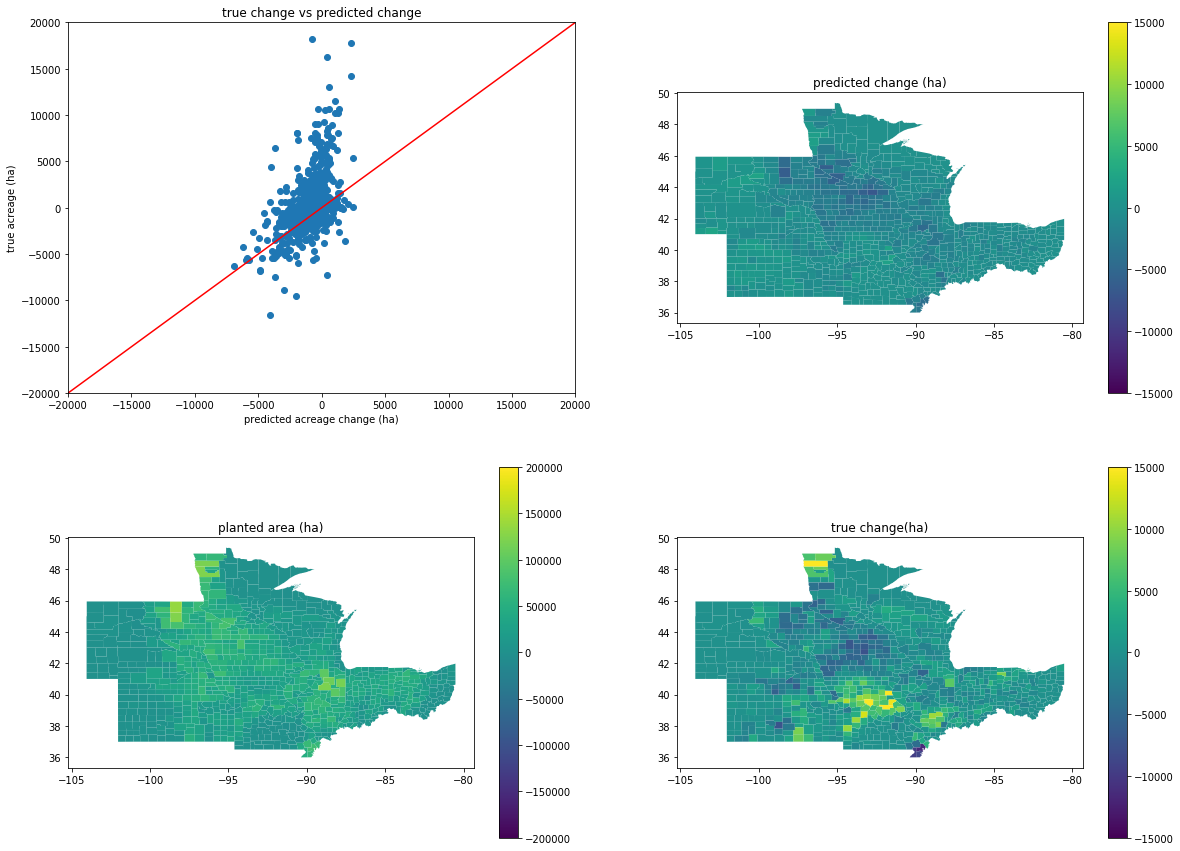

doing prediction for 2017 from 2016
our solution was 0.506922 as close as a naive extrapolation from y-1, y-2
RMSE: 110133.234876 (vs naive extrapolation RMSE of 217258.829226)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2017  corn  South Dakota        154323   177422        -13506  23098             13           True
1  2017  corn          Iowa        283647   192473       -141182  91174             47           True
2  2017  corn        Kansas        138693   432991         66817 294298             68           True
3  2017  corn     Minnesota        165335   243085        -35015  77750             32           True
4  2017  corn      Illinois        180038   212114        117050  32076             15           True
5  2017  corn      Nebraska        242121   199794        -43729  42328             21           True
6  2017  corn      Missouri         63819   147283        327938  83464             57           True
7  2017  corn       Indiana        183144   119910         43135  63234             53           True
8  2017  corn          Ohio        169109   103506         41324  65602             63           True
9  2017  corn     Wisconsin         34149    75401         29867  41252             55           True

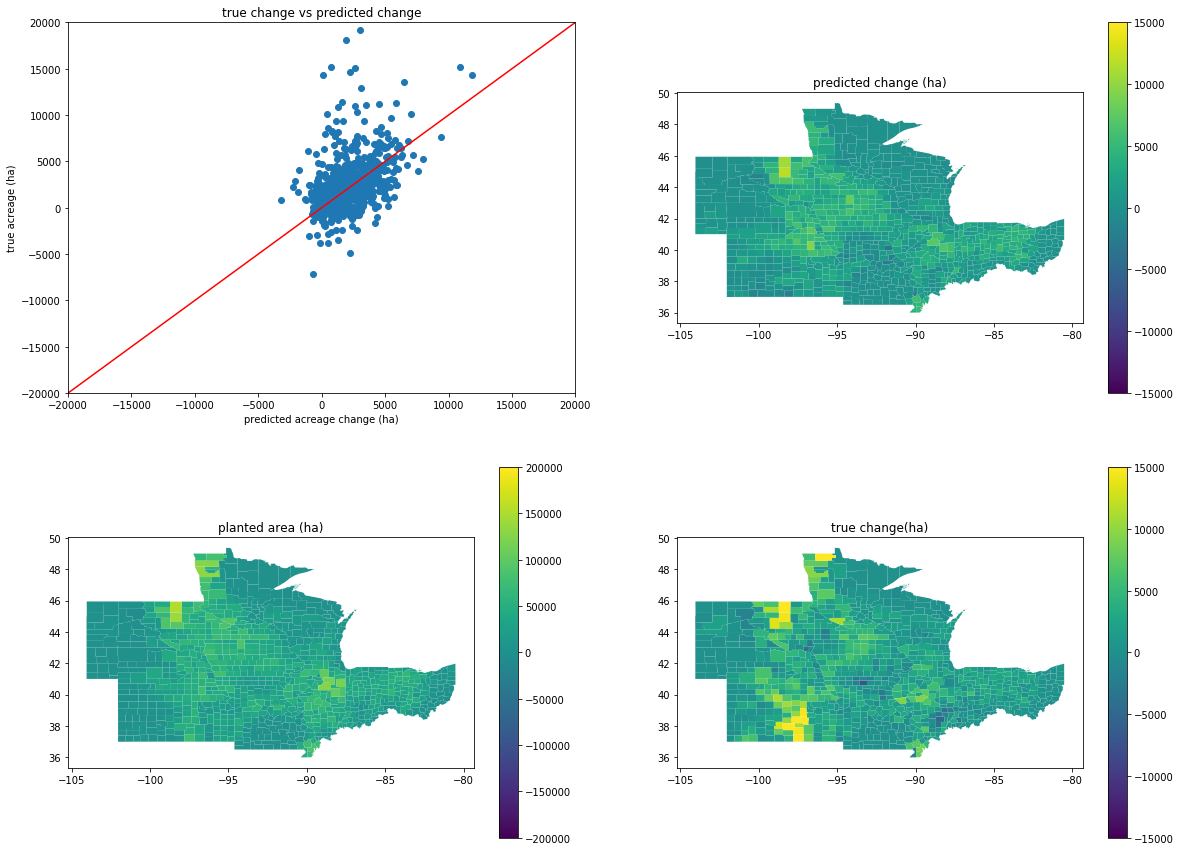

doing prediction for 2018 from 2017
our solution was 0.766458 as close as a naive extrapolation from y-1, y-2
RMSE: 203532.773051 (vs naive extrapolation RMSE of 265549.848165)


year  crop    state_name  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2018  corn  South Dakota       -118334    15363        177422 133697            870          False
1  2018  corn          Iowa       -348188     4564        192473 352752           7728          False
2  2018  corn        Kansas        -78771  -166223        432991  87453             53           True
3  2018  corn     Minnesota       -311160  -135001        243085 176160            130           True
4  2018  corn      Illinois       -355365    67978        212114 423343            623          False
5  2018  corn      Nebraska       -126455   -14569        199794 111886            768           True
6  2018  corn      Missouri       -129186   -46013        147283  83173            181           True
7  2018  corn       Indiana       -130431     5805        119910 136235           2347          False
8  2018  corn          Ohio       -104038   -42858        103506  61180            143           True
9  2018  corn     Wisconsin        -90819    20124         75401 110943            551          False

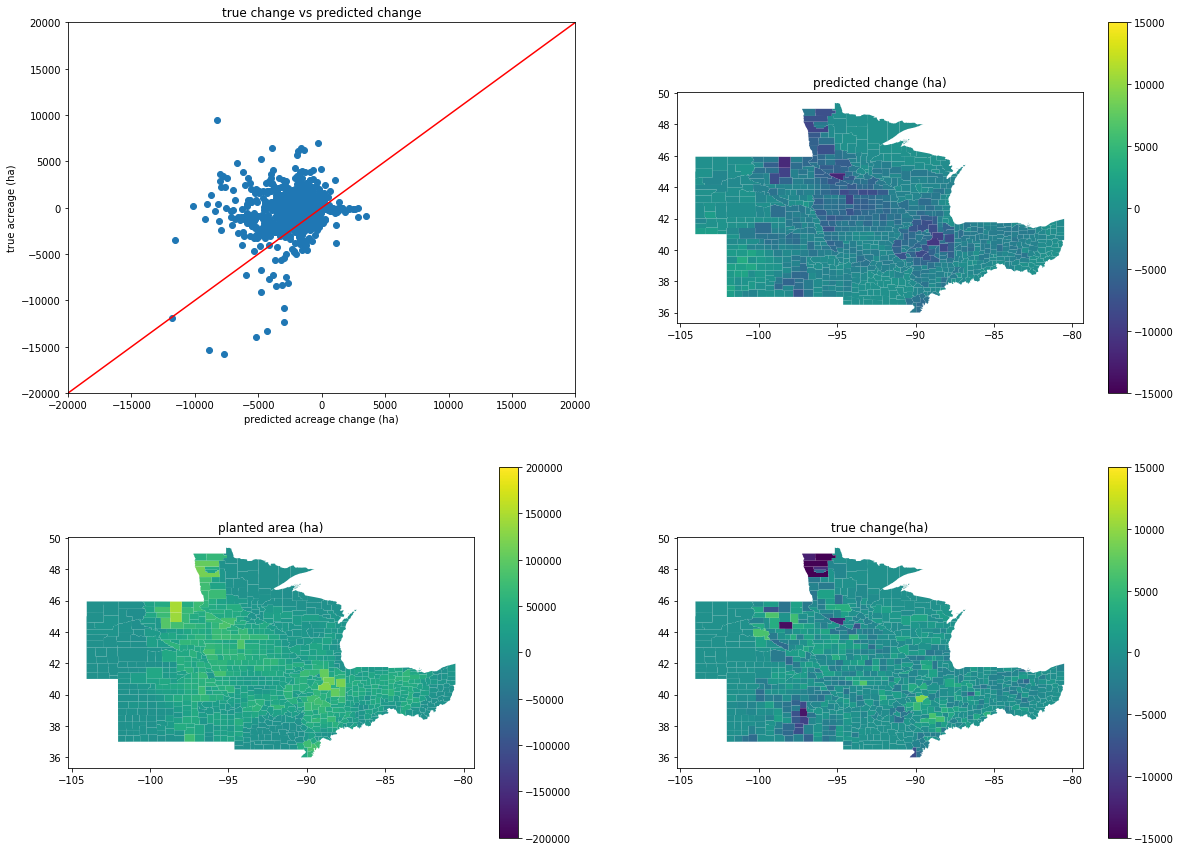

In [72]:
from sklearn import linear_model
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.model_selection import KFold
import geopandas

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 2000)

kf = KFold(n_splits=num_samples-2)
for train_idxs, test_idxs in kf.split([0]*(num_samples-2)): #[(list(range(0,22)), [22])]: 

    predictions_over_all_states = np.array((0))
    true_over_all_states = np.array((0))
    print("doing prediction for %i from %i" % ((test_idxs[0] + 1 + 1995), (test_idxs[0] + 1995)))

    #print("Crop under analysis: " + crop)
    X_flat = X[:, train_idxs, :].reshape(-1, X.shape[-1])
    
    for crop in ["corn"]: 
        
        total_error = 0.0
        total_error_naive = 0.0
        state_results = []
        district_predicted_change = []
        district_actual_change = []
        district_actual_planted = []
        
        y_flat = y[crop][:, train_idxs].reshape(-1)

        #feature_names = np.array(feature_names)
        reg = linear_model.Lasso(alpha=1.0).fit(X_flat, y_flat)

        for name, state_id in state_ids.items():

            s1, s2 = state_index_map[state_id]
            state_X = X[s1:s2, test_idxs, :].reshape((-1,X.shape[-1]))
            state_y = y[crop][s1:s2, :]
            state_y_full = y_full_area[crop][s1:s2, :]

            county_predictions = reg.predict(state_X)
            predicted_sum = np.sum(county_predictions)
            
            predictions_over_all_states = np.append(predictions_over_all_states, county_predictions)
            true_over_all_states = np.append(true_over_all_states, state_y[:, test_idxs[0]])
            
            # no weighting
            true_state_sum = np.sum(state_y[:, test_idxs[0]])
            naive_sum = np.sum(state_y[:, test_idxs[0]-1])
            total_error += np.abs((predicted_sum - true_state_sum)**2)
            total_error_naive += np.abs((naive_sum - true_state_sum)**2)
            error = np.abs(true_state_sum - predicted_sum)
            perc_error = error/np.abs(true_state_sum)*100
            sign_accurate = ((np.sign(predicted_sum) * np.sign(true_state_sum)) > 0)
            state_results.append([(test_idxs[0] + 1 + 1995), 
                                  crop, name, predicted_sum, true_state_sum, naive_sum, error, perc_error, sign_accurate])
            district_predicted_change += county_predictions.tolist()
            district_actual_change += state_y[:, test_idxs[0]].tolist()
            district_actual_planted += state_y_full[:, test_idxs[0]].tolist()

        finalcoef = (np.sqrt(total_error/len(state_ids)) / np.sqrt(total_error_naive/len(state_ids)))
        print("our solution was %f as close as a naive extrapolation from y-1, y-2" % finalcoef)
        print("RMSE: %f (vs naive extrapolation RMSE of %f)" % (np.sqrt(total_error/len(state_ids)), np.sqrt(total_error_naive/len(state_ids))))

        state_results_dataframe = pd.DataFrame(state_results, 
                                               columns=["year", 
                                                        "crop",
                                                        "state_name",  
                                                        "predicted_dy", 
                                                        "true_dy", 
                                                        "last_year_dy", 
                                                        "error", 
                                                        "percent_error", 
                                                        "sign_accurate"])
        pd.options.display.float_format = '{:.0f}'.format
        display(state_results_dataframe)

    fig, axes = plt.subplots(2, 2, figsize=(20,15))
    (ax_scatter, ax_choro_delta, ax_choro_true, ax_choro_true_delta) = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
    x_0 = y_0 = np.min([np.min(predictions_over_all_states), np.min(true_over_all_states)])
    x_1 = y_1 = np.max([np.max(predictions_over_all_states), np.max(true_over_all_states)])

    xlim = ylim = 20000
    
    ax_scatter.plot([-xlim, xlim], [-ylim, ylim], c='r')
    ax_scatter.scatter(predictions_over_all_states, true_over_all_states)

    ax_scatter.set_xlabel("predicted acreage change (ha)")
    ax_scatter.set_ylabel("true acreage (ha)")
    ax_scatter.set_title("true change vs predicted change")
    ax_scatter.set_xlim(-xlim, xlim)
    ax_scatter.set_ylim(-ylim, ylim)
    
    ax_choro_delta.set_title("predicted change (ha)")
    ax_choro_true.set_title("planted area (ha)")
    ax_choro_true_delta.set_title("true change(ha)")
    
    
    df_district["pred_delta_area"] = district_predicted_change
    df_district["true_delta_area"] = district_actual_change
    df_district["true_area"] = district_actual_planted
    
    # This may cause an error if you have GeoPandas < 0.4.0
    
    cfactor = 0.75
    df_district.plot("pred_delta_area", cmap='viridis', legend=True, legend_kwds={"loc":"upper right"}, ax=ax_choro_delta, vmin=-ylim*cfactor, vmax=ylim*cfactor)
    df_district.plot("true_area", cmap='viridis', legend=True, legend_kwds={"loc":"upper right"}, ax=ax_choro_true, vmin=-ylim*10, vmax=ylim*10)
    df_district.plot("true_delta_area", cmap='viridis', legend=True, legend_kwds={"loc":"upper right"}, ax=ax_choro_true_delta, vmin=-ylim*cfactor, vmax=ylim*cfactor)

    
    plt.show()